# **. Import des librairies et du du fichier final**

## **. Import des librairies**

In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
import pca as pca
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn import preprocessing
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from colour import Color
from sklearn import decomposition


from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


# **. Import du fichier final**

In [2]:
df = pd.read_csv('df.csv')
df.head()

Zone  nb_habitant (Millions)  Croissance démographique (%)  \
0  Afrique du Sud                   57.01                         26.78   
1         Albanie                    2.88                         -7.83   
2         Algérie                   41.39                         33.33   
3       Allemagne                   82.66                          1.54   
4          Angola                   29.82                         81.86   

   Import_Volaille (quantité)  TDI volaille (%)  TAS volaille (%)  \
0                       514.0             24.27             78.71   
1                        38.0             80.85             27.66   
2                         2.0              0.72             99.28   
3                       842.0             48.42             87.06   
4                       277.0             86.83             13.17   

   Part de la dispo alimentaire d’origine animale (%)  \
0                                              11.67    
1                                               4.23    
2                                               2.43    
3                                               9.46    
4                                               4.42    

   Part de la dispo alimentaire d’origine volaille (%)  \
0                                               6.41     
1                                               1.30     
2                                               0.80     
3                                               2.06     
4                                               1.85     

   Part des protéines d'origine animale (%)  pib_hab_US$  Inflation (%)  \
0                                     31.09      6121.88           6.90   
1                                     17.54      4514.20           3.92   
2                                      7.68      4109.70           5.04   
3                                     28.30     44651.83           2.76   
4                                     16.88      4095.81          28.91   

   stabilite_politique (%)  
0                    -0.28  
1                     0.38  
2                    -0.92  
3                     0.59  
4                    -0.33

In [3]:
df.rename(columns={'nb_habitant (Millions)': 'nb_habitant','Croissance démographique (%)': 'Croiss.dem',
                       'Part de la dispo alimentaire d’origine animale (%)': 'dispo animale',
                       'Part de la dispo alimentaire d’origine volaille (%)': 'dispo volaille',
                       "Part des protéines d'origine animale (%)": 'dispo Prot.animale',
                       "Import_Volaille (quantité)": 'Import_Volaille','stabilite_politique (%)':'Stab_poltiq.'}, inplace= True)

In [4]:
df.isna().mean()

Zone                  0.0
nb_habitant           0.0
Croiss.dem            0.0
Import_Volaille       0.0
TDI volaille (%)      0.0
TAS volaille (%)      0.0
dispo animale         0.0
dispo volaille        0.0
dispo Prot.animale    0.0
pib_hab_US$           0.0
Inflation (%)         0.0
Stab_poltiq.          0.0
dtype: float64

In [5]:
df.head()

Zone  nb_habitant  Croiss.dem  Import_Volaille  TDI volaille (%)  \
0  Afrique du Sud        57.01       26.78            514.0             24.27   
1         Albanie         2.88       -7.83             38.0             80.85   
2         Algérie        41.39       33.33              2.0              0.72   
3       Allemagne        82.66        1.54            842.0             48.42   
4          Angola        29.82       81.86            277.0             86.83   

   TAS volaille (%)  dispo animale  dispo volaille  dispo Prot.animale  \
0             78.71          11.67            6.41               31.09   
1             27.66           4.23            1.30               17.54   
2             99.28           2.43            0.80                7.68   
3             87.06           9.46            2.06               28.30   
4             13.17           4.42            1.85               16.88   

   pib_hab_US$  Inflation (%)  Stab_poltiq.  
0      6121.88           6.90         -0.28  
1      4514.20           3.92          0.38  
2      4109.70           5.04         -0.92  
3     44651.83           2.76          0.59  
4      4095.81          28.91         -0.33

# **. Préparation des datas**

On vérifie tout d'abord l'échelle de nos données en interrogeant la moyenne et l'écart type de celles ci

In [100]:
#Calcul de la moyenne et de l'écart type
idx = ["mean", "std"]

pd.DataFrame(df).describe().round(2).loc[idx, :]

nb_habitant  Croiss.dem  Import_Volaille  TDI volaille (%)  \
mean        27.03       28.79            82.47             44.05   
std         48.36       28.90           181.35             49.80   

      TAS volaille (%)  dispo animale  dispo volaille  dispo Prot.animale  \
mean             72.87           7.25            2.95               21.62   
std              44.50           3.86            2.44               10.11   

      pib_hab_US$  Inflation (%)  Stab_poltiq.  Groupe kmeans  
mean     14010.12           4.50         -0.02           2.44  
std      19317.60           6.51          0.85           1.06

Les unités des variables étant différentes elles ont un impacte sur la dispersion des données ce qui les rends difficilement comparable.

Il est donc nécessaire de mettre nos données à la même échelle

## **. Normalisation des datas**

**<ins>DEFINITION ET FONCTIONNEMENT</ins>**

<ins>La normalisation</ins> est une opération de pré-traitement de données qui a pour but de mettre sur une même échelle toutes les variables quantitatives afin de faciliter leur comparaison

* Pour réaliser cette mise à l'échelle nous devons:

    * <ins>Centrer nos données</ins>: faire en sorte que leur moyenne soit égale à 0 (*on soustraire à toutes ces observations leur moyenne*).
    * <ins>Réduire nos données</ins> : que leur variance soit égale à 1 (*on les divise par leur écart-type c'est à dire la racine carrée de la variance).*

**<ins>DATA SPLIT</ins>**

On sépare nos données qualitative et quantitative en créant une matrice X qui contiendra nos données quantitative sans oublier de placer au préalable notre colonne " <ins>Zone</ins> " en Index au sein de notre df initial. 

On place également nos colonnes dans une variables que nous appellerons features

In [101]:
#Indexation selon les pays 
df.set_index('Zone', inplace=True)

on enregistre les noms de nos colonnes dans la variables features

In [102]:
features = df.columns
features

Index(['nb_habitant', 'Croiss.dem', 'Import_Volaille', 'TDI volaille (%)',
       'TAS volaille (%)', 'dispo animale', 'dispo volaille',
       'dispo Prot.animale', 'pib_hab_US$', 'Inflation (%)', 'Stab_poltiq.',
       'Groupe kmeans'],
      dtype='object')

On crée une matrice qui contiendra toutes les valeurs quantitatives de notre df

In [103]:
#Matrice des valeurs quantitatives 
X = df.values
X.shape

(166, 12)

In [104]:
#On vérifie que la matrice est bien un np.array : 
type(X)

numpy.ndarray

In [105]:
#on affiche les données pour vérifier que celà a fonctionné
X[:1]

array([[ 5.70100e+01,  2.67800e+01,  5.14000e+02,  2.42700e+01,
         7.87100e+01,  1.16700e+01,  6.41000e+00,  3.10900e+01,
         6.12188e+03,  6.90000e+00, -2.80000e-01,  1.00000e+00]])

**<ins>SCALING</ins>**

<ins>**DEFINITION ET FONCTIONNEMENT**</ins>

* **Scaling**

Un produit scalaire est une opération algébrique entre 2 vecteurs. Dans notre cas, cette opération associe à 2 vecteurs un nombre réel.c'est ce produit scalaire qui permettra de calculer des distances, des longueurs, des projections et des angles

**Les opérations de centrage et réduction permettent de mettre nos données à la même échelle**:

*Pour mettre nos données à la même échelle on les transforme afin que leurs moyennes soient toutes égales et que leurs variances le soient aussi.C'est à dire moyenne = 0 et variance = 1*

**Centrer les données**
    
Pour effectuer un centrage sur des observations, il faut soustraire à toutes ces observations leur moyenne afin que leurs moyennes soient égales à 0. Centrer les données déplace le nuage de points de telle manière que son centre de gravité coïncide avec l’origine du repère.

 **Réduire les données**
Après avoir centré les données, si on les divise par leur écart-type (l’écart-type est la racine carrée de la variance) alors on obtient des valeurs dont la variance vaut 1.

* *Opération de centrage et de réduction des datas*

In [106]:
#Centrage / réduction des données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

* *On vérifie que la moyenne est égale à 0 et l'écart type à 1*

In [107]:
#Calcul de la moyenne et de l'écart type
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

0    1    2    3    4    5    6    7    8    9    10   11
mean  0.0  0.0 -0.0  0.0 -0.0  0.0 -0.0  0.0  0.0  0.0 -0.0 -0.0
std   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

# **. Clustering Hierarchique**

<ins>**DEFINITION ET FONCTIONNEMENT**</ins>

<ins>Le Clustering</ins> permet de regrouper des individus au sein de groupes spécifiques et homogènes.On peut alors isoler certains groupes, et travailler plus en détail sur leurs individus propres. Faire un clustering, c'est regrouper ensemble les points les plus proches, ou les plus semblables. Le concept de clustering repose sur ceux de distance et de similarité.


<ins>La classification hiérarchique</ins> permet de créer un arbre qui regroupe les différents individus de façon plus ou moins forte en fonction de la distance qui les sépare. Cela nous permettra d'avoir une première approche des similitudes entre les pays en les classant par groupes d'individus similaires et permettra de  faciliter l'étude de leurs comportements.

<ins>**CRITERES**</ins>

Nous voulons de nos clusters qu'ils soient :

* Resserrés sur eux-mêmes : deux points qui sont proches doivent appartenir au même cluster ;

* Loin les uns des autres : deux points qui sont éloignés doivent appartenir à des clusters différents.


## **. CAH Dendrograme**

<ins>**DEFINITION ET FONCTIONNEMENT**</ins>

<ins>Le dendrograme</ins> est un arbre qui regroupe les différents clusters. L'approche ascendante considère tout d'abord que chaque point est un cluster. Il y a donc autant de clusters que de points. Ensuite, on cherche les deux clusters les plus proches, et on les agglomère en un seul cluster. On répète cette étape jusqu'à ce que tous les points soient regroupés en un seul grand cluster.On obtient donc une arborescence qui a un cluster tout en haut, et qui se divise petit à petit jusqu'à avoir autant de clusters que de points. On appelle cette arborescence un dendrogramme

<ins>**PARAMETRAGE MESURE DE LA DISTANCE**</ins>

Afin de pouvoir réaliser notre Dendrograme nous devons tout d'abord définir une <ins>métric de distance</ins> entre les clusters. Nous utilisons ici <ins>La Distance Euclidienne</ins> et la <ins>Méthode de Ward</ins>.

<ins>La Distance Euclidienne</ins> : permet d’évaluer la distance entre les centroïdes. A chaque étape de regroupement entre deux centroïdes on obtiendra un nouveau cluster et un nouveau centroïde qui est autre le centre de gravité du nuage de points. (espace géométrique classique).Un espace Euclidien c'est un espace dans lequel des droites parallèles ne se croisent pas, la somme des angles d'un triangle fait 180°, etc.Un espace euclidien, c'est en quelque sorte un espace « plat ».

<ins>L’inertie intraclasse</ins> : C'est la somme des distances euclidiennes entre chaque point associé au cluster et le centre gravité nouvellement calculé

<ins>La Méthode de Ward</ins> permet de de minimiser l'augmentation de l'inertie en garantissant que les clusters sont bien séparés mais également resserrés sur eux-mêmes : à chaque itération, c'est-à-dire à chaque fois que 2 clusters sont regroupés en 1. L'algorythme cherche à minimiser l'augmentation d'inertie intraclasse due au regroupement des 2 clusters.


On crée une matrice Z qui intègre nos données centrées réduite et prend en paramètre la methode 'Ward' et la 'Distance euclidienne'

In [108]:
#Création matrice de distance appellée Z
Z = linkage(X_scaled, method = 'ward', metric='euclidean')
pd.DataFrame(Z)

0      1          2      3
0    107.0  130.0   0.460139    2.0
1     24.0   27.0   0.511510    2.0
2    115.0  131.0   0.542427    2.0
3     76.0  126.0   0.551753    2.0
4     44.0   65.0   0.640836    2.0
..     ...    ...        ...    ...
160  313.0  321.0  14.029402   23.0
161  306.0  326.0  14.992527   30.0
162  318.0  325.0  18.623906   73.0
163  323.0  327.0  18.959350   93.0
164  328.0  329.0  29.765494  166.0

[165 rows x 4 columns]

<ins>**GRAPHIQUE**</ins>

**1. <ins> On affiche un premier Dendrograme</ins>** 

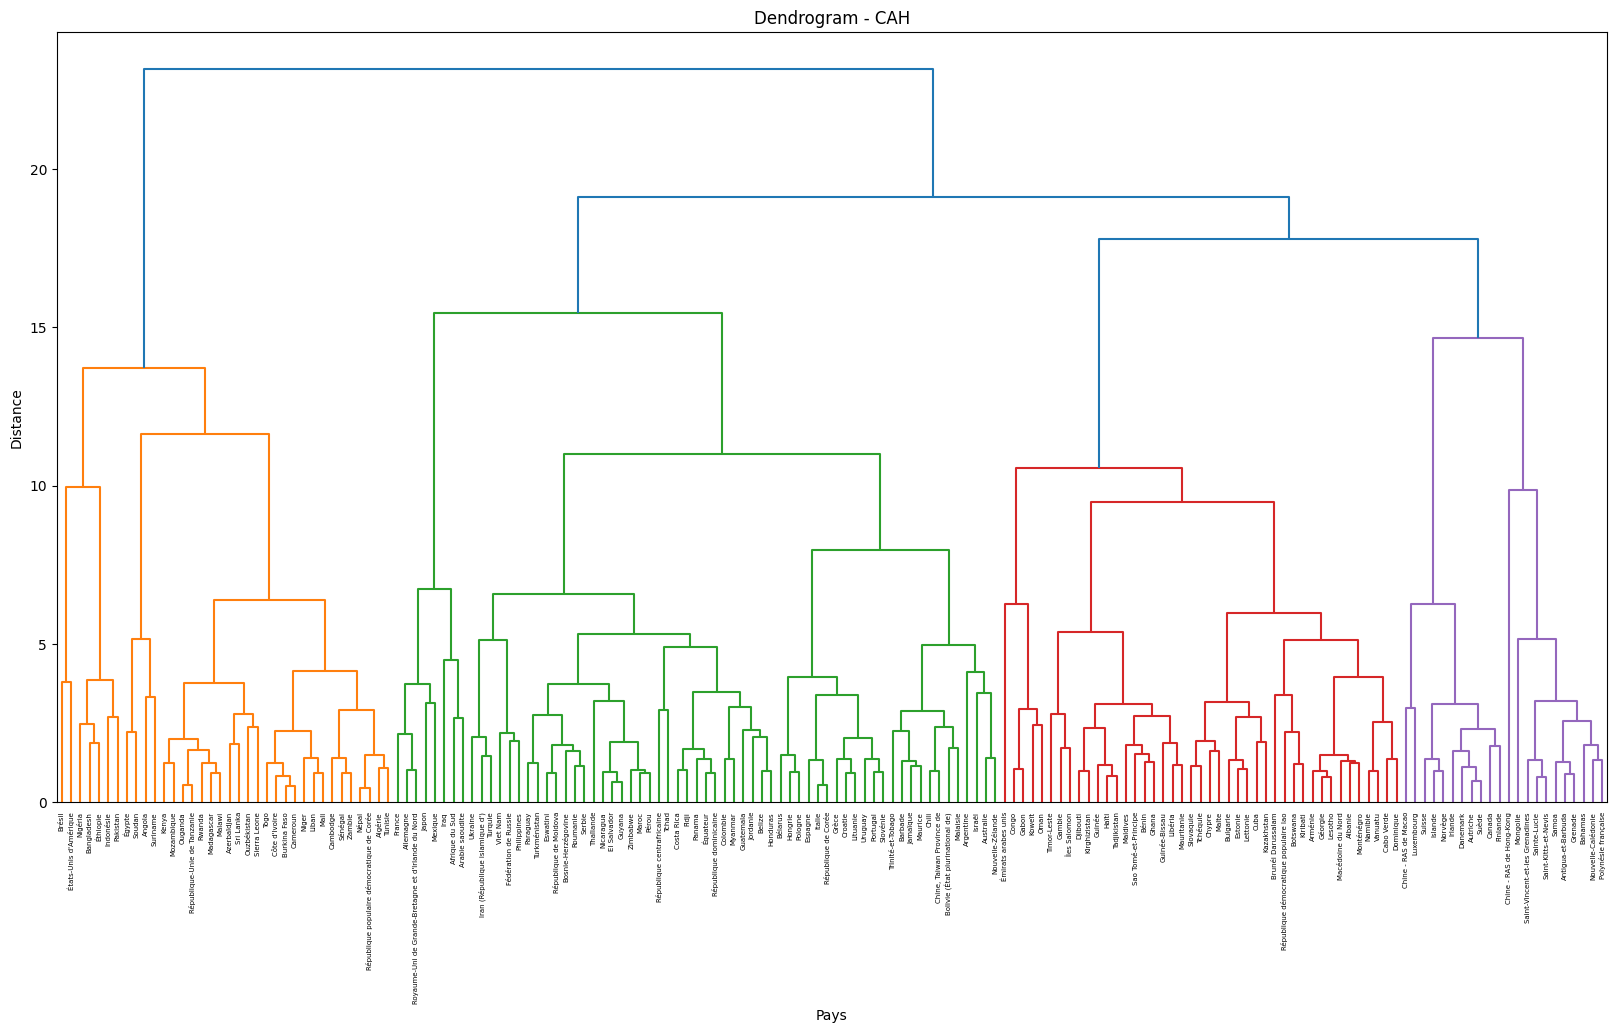

In [15]:
#Dendrograme 
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.set_style('white')

_ = dendrogram(Z,labels = df.index)

plt.title("Dendrogram - CAH")
plt.xlabel("Pays")
plt.ylabel("Distance")
plt.savefig("dendrogramme1.png")
plt.show()

y = la distance entre les échantillons

Z = les individus (Pays)

**2. <ins> Interprétation</ins>** 

<ins>Aide à la décision dans le découpage du Dendrogramme</ins> 

* La coupure doit se faire lors d’un saut important de l’indice par inspection visuelle de l’arbre.
Ce saut traduit le passage brutal entre des classes d’une certaine homogénéité de l’ensemble à des classes beaucoup moins homogènes.

* Dans la plupart des cas, il y a plusieurs paliers et donc plusieurs choix de partitions possibles.

Le saut le plus important est représenté par la ligne bleue, nous avons également un autre saut sur la ligne verte.Coupons le dendrogramme à partir de ces 2 lignes.

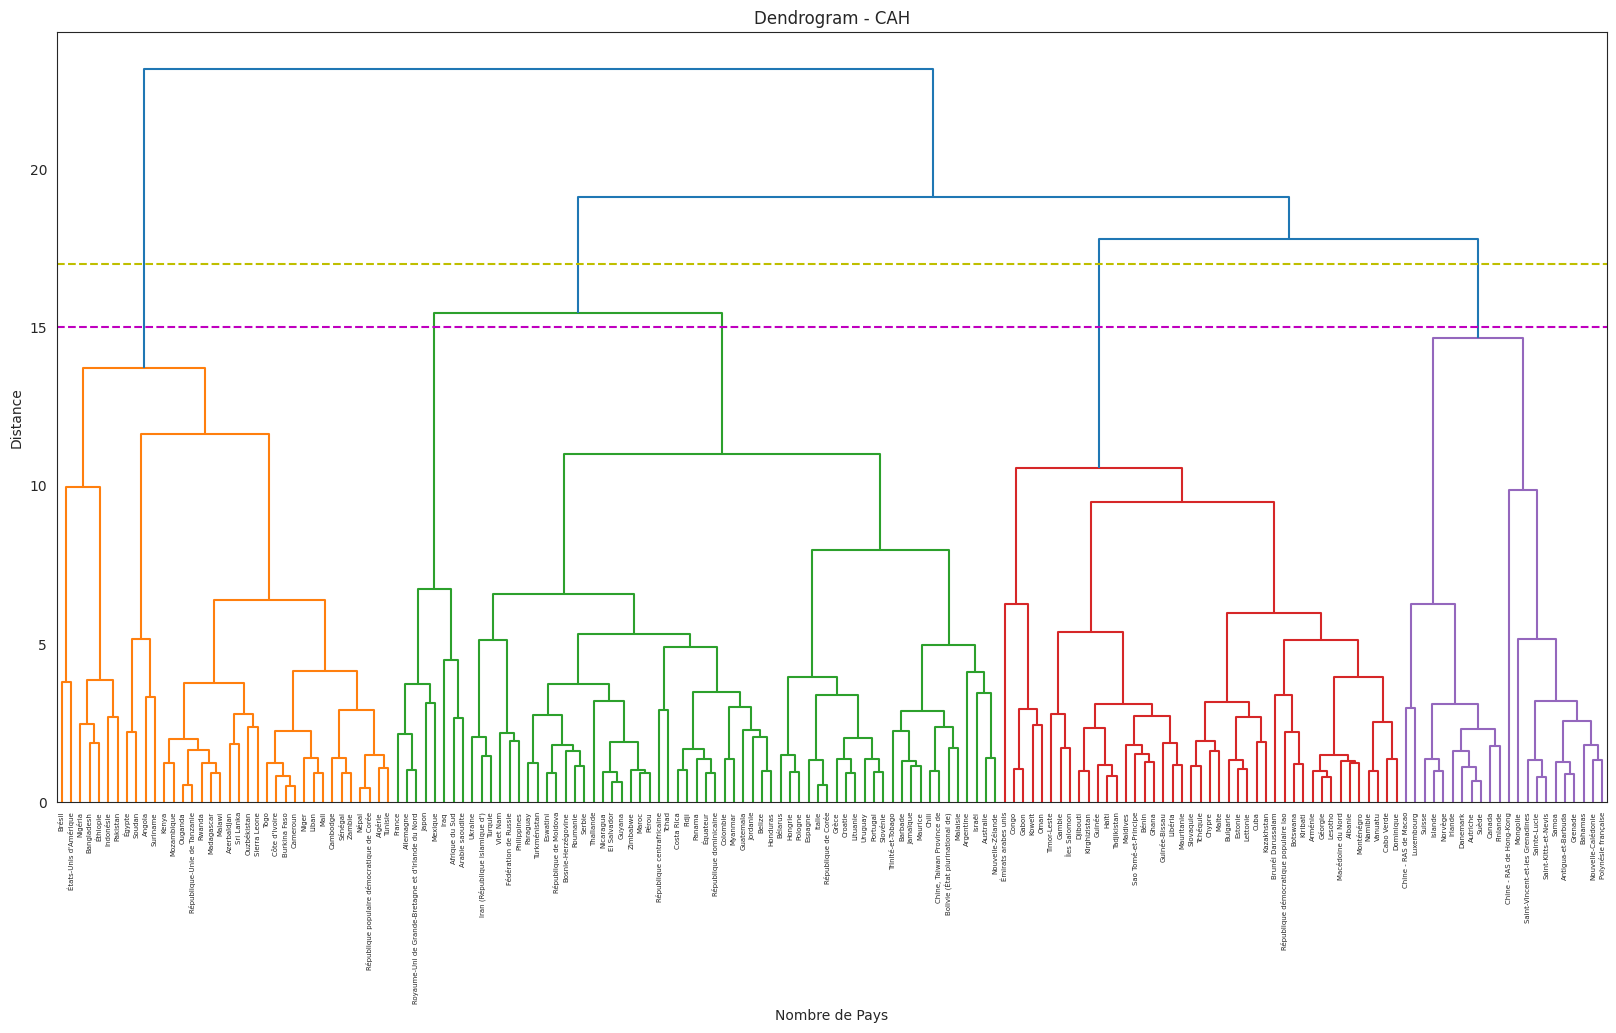

In [16]:
#Dendrograme 
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.set_style('white')
_ = dendrogram(Z,labels = df.index)

plt.title("Dendrogram - CAH")
plt.xlabel("Nombre de Pays")
plt.ylabel("Distance")
plt.axhline(y=17,ls='--',color ="y")
plt.axhline(y=15,ls='--',color ="m")
plt.savefig("dendrogramme1.png")
plt.show()


Découpons notre dendrogramme en 4 ou 5 groupes pour avoir le nombre de pays par groupes

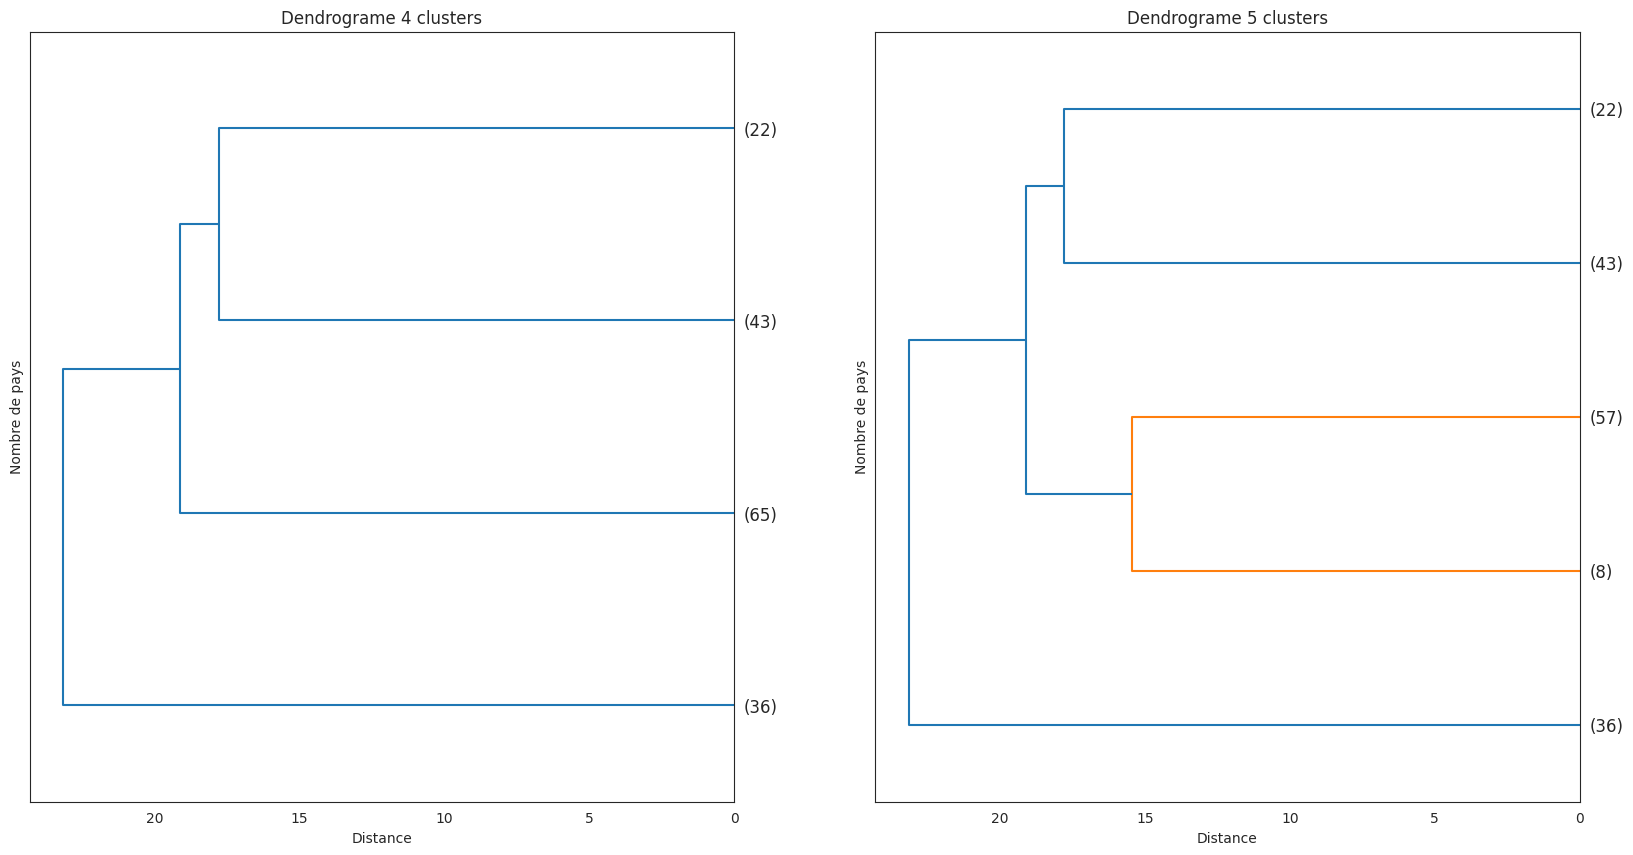

In [17]:
# Coupage du dendrogramme en 4 et 5 groupes 

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plt.subplot(121)
_ = dendrogram(Z, p=4, truncate_mode="lastp",labels = df.index,orientation='left')
plt.title("Dendrograme 4 clusters")
plt.xlabel("Distance")
plt.ylabel("Nombre de pays")

plt.subplot(122)
_ = dendrogram(Z, p=5, truncate_mode="lastp",labels = df.index,orientation='left')
plt.title("Dendrograme 5 clusters")
plt.xlabel("Distance")
plt.ylabel("Nombre de pays")
plt.show()

**<ins>Pour  clusters nous avons la répartition suivante</ins> :**
    
 **groupe 1** : 22 pays - 
 **groupe 2** : 43 pays - 
 **groupe 3** : 65 pays - 
 **groupe 4** : 36 pays

**<ins>Pour 5 clusters nous avons la répartition suivante</ins> :**

**groupe 1** : 22 pays - 
**groupe 2** : 43 pays - 
**groupe 3** : 57 pays - 
**groupe 4** : 8 pays - 
**groupe 5** : 36 pays 


<ins>**Conclusion**</ins> : 

On remarque que le découpage en 5 clusters nous permet de redécouper le groupe de 65 pays en 57 et 8 pays, il y aurait donc un cluster supplémentaire de 8 pays.

Afin de déterminer quel est le cluster le plus performant nous allons utiliser d'autre outils d'aide à la décision pour faire notre choix en comparant la performance de ces 2 clusters.

# **. Methode des KMeans**

Le clustering K-means en Python est un type d’apprentissage automatique non supervisé, ce qui signifie que l’algorithme ne s’entraîne que sur des entrées et aucune sortie. Il fonctionne en trouvant les groupes distincts de données (c.-à-d. les grappes) qui sont les plus proches les uns des autres. Plus précisément, il partitionne les données en clusters dans lesquels chaque point tombe dans un cluster dont la moyenne est la plus proche de ce point de données.

## **. Methode du coude**

Méthode du coude

K-Means est un algorithme qui regroupe les données dans le nombre K de clusters que nous lui spécifions au départ, même s'il ne s'agit pas du nombre optimal de clusters pour l'ensemble de données.

KElbowVisualizer de Yellowbrick implémente la méthode "coude" de sélection du nombre optimal de clusters en ajustant le modèle K-Means avec une plage de valeurs pour K
 . Si le graphique linéaire ressemble à un bras, alors le « coude » (le point d'inflexion sur la courbe) est une bonne indication que le modèle sous-jacent s'adapte le mieux à ce point.
 
La métrique du paramètre de notation est définie sur la distorsion, qui calcule la somme des distances au carré entre chaque point et son centre attribué. La méthode de Ward n'est pas possible dans la méthode Yellowbrick.

Le graphique affiche également le temps nécessaire pour ajuster le modèle par K ( *peut être masqué en définissant timings=False* ). 


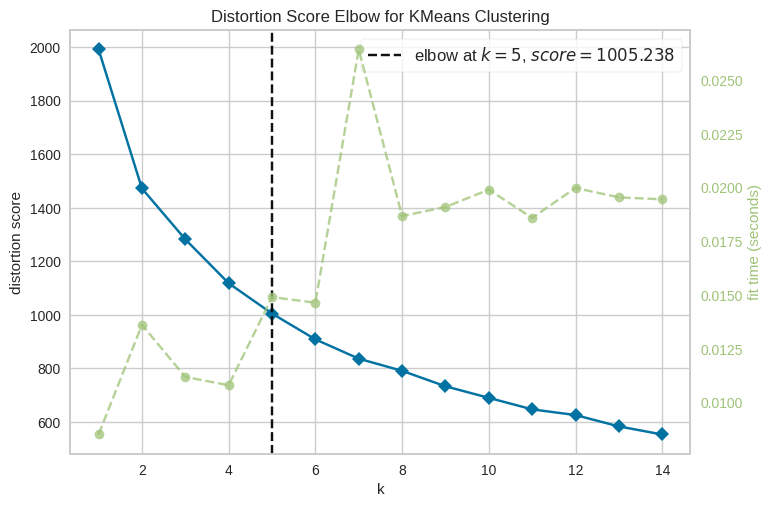

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [111]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,15), metric='distortion')
visualizer.fit(X_scaled)
visualizer.show()


En utilisant le KElbowVisualizer celui ci ajuste le modèle pour une plage de K valeurs de 1 à 15, qui est défini par le paramètre k=(1,15). Lorsque le modèle est ajusté avec 5 clusters, nous pouvons voir un "coude" dans le graphique, qui est donc le nombre de cluster optimal 

<ins>**Conclusion**</ins> : 
L'utilisation de cet outil oriente vers le choix de 5 clusters.Le découpage en 5 clusters serait plus performant que le découpage en 4 clusters. 

complétons l'étude avec les indices de Davies Bouldine et Calinski Harabasz qui permettent d'évaluer la qualité de la performance des clusterings

## **. Indice de Davies Bouldin**

L’indice Davies-Bouldin (DBI) est l’une des mesures d’évaluation des algorithmes de clustering. Il est le plus souvent utilisé pour évaluer la qualité de la division par un algorithme de clustering K-Means pour un nombre donné de clusters

L’indice Davies-Bouldin est calculé comme la similarité moyenne de chaque grappe avec une grappe la plus similaire.

C'est la moyenne du rapport maximal entre la distance d'un point au centre de son groupe et la distance entre deux centres de groupes

<ins>**Méthode d'interprétation:**</ins>
    
Plus l’indice de Davies-Bouldin (plus la similarité moyenne est faible), mieux les grappes sont séparées et meilleur est le résultat du regroupement effectué.

In [22]:
results = {}

for i in range(2,10):
    kmeans = KMeans(n_clusters=i, random_state=30)
    labels = kmeans.fit_predict(X_scaled)
    db_index = davies_bouldin_score(X_scaled, labels)
    results.update({i: db_index})

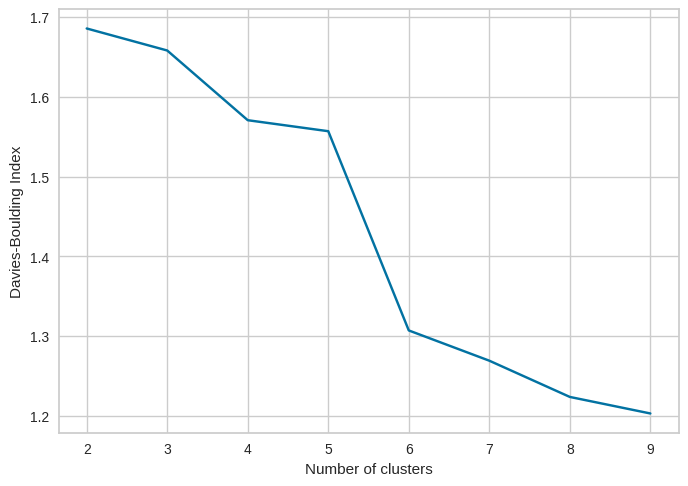

In [23]:
plt.plot(list(results.keys()), list(results.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Boulding Index")
plt.show()

<ins>**Conclusion**</ins> :

Si l'on compare la performance des clusters 4 et 5 on remarque que le cluster le plus performant est de 5 (score le plus faible) cependant les scores semblent assez proche.

Utilisons le score de calinski harabasz afin de compléter notre étude du choix optimal de cluster

## **. Coefficient Calinski Harabasz**

l’indice Calinski-Harabasz est une autre mesure permettant d’évaluer la performance du clustering.

L’indice de Calinski-Harabasz (également connu sous le nom de critère du rapport de variance) est calculé comme un rapport entre la somme de la dispersion inter-grappes et la somme de la dispersion intra-cluster pour tous les clusters (où la dispersion est la somme des distances au carré)

<ins>**Méthode d'interprétation:**</ins>

Un score élevé signifie un meilleur regroupement puisque les observations dans chaque amas sont plus proches les unes des autres (plus denses), tandis que les amas eux-mêmes sont plus éloignés les uns des autres (bien séparés).

In [24]:
results = {}

for i in range(2,10):
    kmeans = KMeans(n_clusters=i, random_state=30)
    labels = kmeans.fit_predict(X_scaled)
    db_index = calinski_harabasz_score(X_scaled, labels)
    results.update({i: db_index})

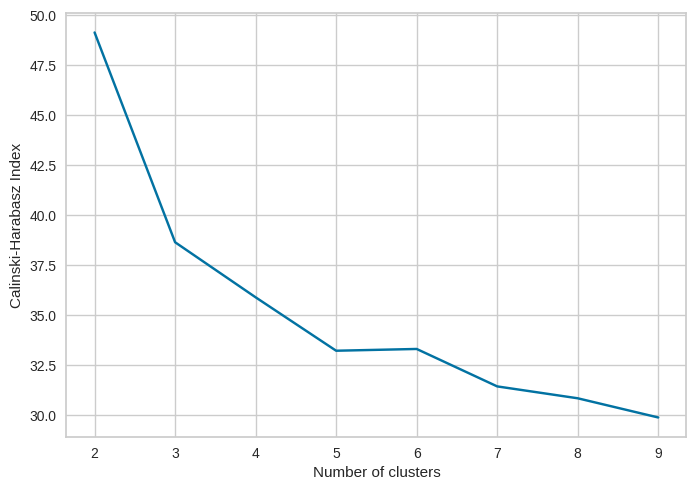

In [25]:
plt.plot(list(results.keys()), list(results.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Calinski-Harabasz Index")
plt.show()

In [26]:
#score Calinski Harabasz pour les clusters 4,5,6

for i in [4, 5, 6]:
    kmeans = KMeans(n_clusters=i, random_state=30)
    labels = kmeans.fit_predict(X_scaled)
    ch_index = calinski_harabasz_score(X_scaled, labels)
    print(ch_index)

35.87298372350282
33.19910945215956
33.287593882106655


<ins>**Conclusion**</ins> :

Si l'on compare à nouveau la performance des clusters 4 et 5 on remarque que le cluster le plus performant est de 4 (score le plus élevé) 5 présentant un indice plus faible mais encore une fois les scores sont trés proche.

Concluons notre recheche du nombre optimal de clusters avec le coefficient de silhouette.

## **. Coefficient de silhouette**

Une autre façon de quantifier notre nombre de cluster est de mesurer le coefficient de silhouette.

L'analyse de silhouette peut être utilisée pour évaluer la densité et la séparation entre les clusters. Le score est calculé en faisant la moyenne du coefficient de silhouette pour chaque échantillon, qui est calculé comme la différence entre la distance intra-grappe moyenne et la distance moyenne de la grappe la plus proche pour chaque échantillon, normalisée par la valeur maximale. Cela produit un score compris entre -1 et +1, où les scores proches de +1 indiquent une séparation élevée et les scores proches de -1 indiquent que les échantillons ont peut-être été affectés au mauvais groupe.

Le SilhouetteVisualizer affiche le coefficient de silhouette pour chaque échantillon sur une base par grappe, permettant aux utilisateurs de visualiser la densité et la séparation des grappes. Ceci est particulièrement utile pour déterminer le déséquilibre du cluster ou pour sélectionner une valeur pour K en comparant plusieurs visualiseurs.

Nous avons vu précédemment avec le dendrogramme et la méthode du coude que le nombre de cluster idéal se situait entre 3 et 5 clusters. Afin de déterminer le bo nombre de cluster nous utilisons la méthode du coefficient de silhouette afon de pouvoir statuer sur la valeure optimale de K




### **. Diagramme de silhouette Yellowbrick methode**

<ins>Aide à la décision</ins>

Afin de valider le découpage les conditions suivantes doivent être vérifiées pour choisir le bon « K » à l’aide des diagrammes Silhouette:

* Pour un K particulier, tous les clusters doivent avoir un score de silhouette supérieur au score moyen de l’ensemble de données (représenté par la ligne en pointillée rouge). L’axe des x représente le score Silhouette. 

* Il ne devrait pas y avoir de grandes fluctuations dans la taille des grappes. La largeur des clusters représente le nombre de points de données.

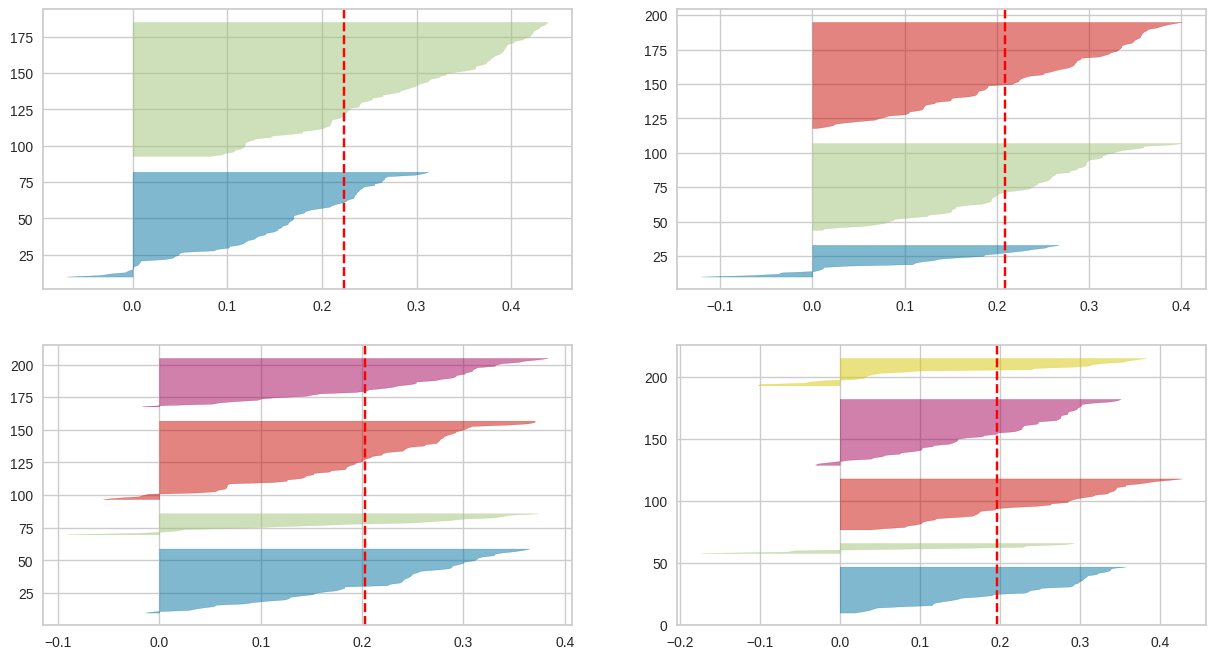

In [27]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

#on affiche les graph pour k=2,3,4 et 5
 
fig, ax = plt.subplots(2, 2, figsize=(15,8))

for i in [2, 3, 4, 5]:
   
    km = KMeans(n_clusters=i,init='k-means++', n_init=10, max_iter=100,random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_scaled) 


In [28]:
from sklearn.metrics import silhouette_score
silhouette_scores = []

for k in [2,3, 4, 5, 6]:
    model2 = KMeans(n_clusters=k, random_state=42)
    model2.fit(X_scaled)
    score = silhouette_score(X_scaled, model2.labels_)
    print("Le score de Silhouette pour k = ", k, "est de", score)
    silhouette_scores.append(score)

Le score de Silhouette pour k =  2 est de 0.22379701516175346
Le score de Silhouette pour k =  3 est de 0.20914176499478856
Le score de Silhouette pour k =  4 est de 0.2030270676656985
Le score de Silhouette pour k =  5 est de 0.1962836220349481
Le score de Silhouette pour k =  6 est de 0.20247999409620326


<ins>**Conclusion**</ins> :

Si l'on compare les clusters 4 et 5 on remarque à nouveau que les scores sont trés proche, 4 restant le plus élevé.3 Tests sur 4 orientent le choix vers 4 clusters, nous choisissons donc le découpage en 4 clusters.


# **. Choix nombre de cluster**

Afin d'orienter notre choix de clusters nous avons utiliser différentes méthodes et différentes métriques :

* La CAH avec un dendrogramme ayant pour paramètre la méthode de ward et la distance euclidienne

* Les Kmeans :
    
    * Avec la méthode du coude et la métrique distortion
    * Avec le score de Davies-Bouldine
    * Avec le score Calinski-Harabasz
    * Avec le score de silhouette  

* Le dendrogramme nous a permis de d'identifier 2 clusters potentiellement interessant que sont les clusters 4 et 5 et d'avoir la répartirion du nombre de pays par clusters.

* L'utilisation de la méthode du coude indique que le cluster le plus indiqué serait le 5 

* Les scores de Davies Bouldine et Calinski Harabasz nous ont permis de voir que le cluster 4 est plus performant qu'un clustering de 5

* Et le score de silhouette nous a permis de conclure sur un choix de k=4 conforté par la répartition des groupes visualisés au niveau des diagrammes.

# **. Choix methode de partitionnement : kmeans ou CAH**

## **. Partitionnement K_Means**

In [29]:
#On instancie les groupes
kmeans = KMeans(init="random", n_clusters=4, n_init=10, random_state=42)

#On fit k-means algorithm en data
kmeans.fit(X_scaled)

#on affiche les clusters
kmeans.labels_

array([0, 3, 2, 0, 3, 0, 0, 1, 3, 0, 0, 2, 0, 2, 1, 1, 1, 3, 1, 1, 3, 1,
       3, 1, 2, 3, 2, 2, 0, 1, 0, 0, 1, 0, 1, 3, 1, 2, 1, 3, 0, 3, 3, 2,
       1, 0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 0, 3, 3, 3, 3, 1, 0, 1, 3, 3, 1,
       3, 1, 1, 3, 2, 2, 3, 0, 0, 0, 1, 1, 0, 1, 1, 2, 3, 3, 0, 3, 1, 2,
       3, 1, 0, 3, 2, 1, 2, 3, 2, 0, 1, 1, 3, 0, 0, 3, 2, 1, 3, 2, 1, 2,
       2, 0, 0, 0, 3, 2, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 3, 1, 2, 2,
       1, 0, 2, 0, 0, 0, 0, 3, 2, 1, 2, 1, 1, 2, 2, 0, 0, 3, 3, 2, 1, 1,
       3, 2, 0, 2, 1, 2, 2, 1, 3, 1, 2, 2], dtype=int32)

In [30]:
#identification des clusters avec la méthode k_means
df['Groupe kmeans'] = kmeans.labels_
df.head()

nb_habitant  Croiss.dem  Import_Volaille  TDI volaille (%)  \
Zone                                                                         
Afrique du Sud        57.01       26.78            514.0             24.27   
Albanie                2.88       -7.83             38.0             80.85   
Algérie               41.39       33.33              2.0              0.72   
Allemagne             82.66        1.54            842.0             48.42   
Angola                29.82       81.86            277.0             86.83   

                TAS volaille (%)  dispo animale  dispo volaille  \
Zone                                                              
Afrique du Sud             78.71          11.67            6.41   
Albanie                    27.66           4.23            1.30   
Algérie                    99.28           2.43            0.80   
Allemagne                  87.06           9.46            2.06   
Angola                     13.17           4.42            1.85   

                dispo Prot.animale  pib_hab_US$  Inflation (%)  Stab_poltiq.  \
Zone                                                                           
Afrique du Sud               31.09      6121.88           6.90         -0.28   
Albanie                      17.54      4514.20           3.92          0.38   
Algérie                       7.68      4109.70           5.04         -0.92   
Allemagne                    28.30     44651.83           2.76          0.59   
Angola                       16.88      4095.81          28.91         -0.33   

                Groupe kmeans  
Zone                           
Afrique du Sud              0  
Albanie                     3  
Algérie                     2  
Allemagne                   0  
Angola                      3

In [31]:
df['Groupe kmeans']= df['Groupe kmeans'].replace([0,1,2,3],[1,2,3,4])

In [32]:
df['Groupe kmeans'].unique()

array([1, 4, 3, 2], dtype=int32)

In [33]:
Kmeans_clust=df['Groupe kmeans']

In [34]:
#df.reset_index(level=0, inplace=True)

## **. Partitionnement CAH**

In [35]:
df2 = pd.read_csv('df.csv')
df2.head()

Zone  nb_habitant (Millions)  Croissance démographique (%)  \
0  Afrique du Sud                   57.01                         26.78   
1         Albanie                    2.88                         -7.83   
2         Algérie                   41.39                         33.33   
3       Allemagne                   82.66                          1.54   
4          Angola                   29.82                         81.86   

   Import_Volaille (quantité)  TDI volaille (%)  TAS volaille (%)  \
0                       514.0             24.27             78.71   
1                        38.0             80.85             27.66   
2                         2.0              0.72             99.28   
3                       842.0             48.42             87.06   
4                       277.0             86.83             13.17   

   Part de la dispo alimentaire d’origine animale (%)  \
0                                              11.67    
1                                               4.23    
2                                               2.43    
3                                               9.46    
4                                               4.42    

   Part de la dispo alimentaire d’origine volaille (%)  \
0                                               6.41     
1                                               1.30     
2                                               0.80     
3                                               2.06     
4                                               1.85     

   Part des protéines d'origine animale (%)  pib_hab_US$  Inflation (%)  \
0                                     31.09      6121.88           6.90   
1                                     17.54      4514.20           3.92   
2                                      7.68      4109.70           5.04   
3                                     28.30     44651.83           2.76   
4                                     16.88      4095.81          28.91   

   stabilite_politique (%)  
0                    -0.28  
1                     0.38  
2                    -0.92  
3                     0.59  
4                    -0.33

In [36]:
df2.rename(columns={'nb_habitant (Millions)': 'nb_habitant','Croissance démographique (%)': 'Croiss.dem',
                       'Part de la dispo alimentaire d’origine animale (%)': 'dispo animale',
                       'Part de la dispo alimentaire d’origine volaille (%)': 'dispo volaille',
                       "Part des protéines d'origine animale (%)": 'dispo Prot.animale',
                       "Import_Volaille (quantité)": 'Import_Volaille','stabilite_politique (%)':'Stab_poltiq.'}, inplace= True)

In [37]:
#Indexation selon les pays 
df2.set_index('Zone', inplace=True)

In [38]:
features2 = df2.columns
features2

Index(['nb_habitant', 'Croiss.dem', 'Import_Volaille', 'TDI volaille (%)',
       'TAS volaille (%)', 'dispo animale', 'dispo volaille',
       'dispo Prot.animale', 'pib_hab_US$', 'Inflation (%)', 'Stab_poltiq.'],
      dtype='object')

In [39]:
#Matrice des valeurs quantitatives 
X2 = df2.values
X2.shape

(166, 11)

In [40]:
#Centrage / réduction des données 
std_scale2 = preprocessing.StandardScaler().fit(X2)
X_scaled2 = std_scale2.transform(X2)

In [41]:
#Identification des 4 groupes 
groupes = fcluster(Z, 4, criterion='maxclust')

#On réalise un tri indirect le long de l’axe
idx = np.argsort(groupes)
dendro4= pd.DataFrame(df2.index[idx], groupes[idx]).reset_index()
#on renomme la colonne index
dendro4 = dendro4.rename(columns={'index':'Groupe CAH'})

In [42]:
#on merge notre fichier avec le df initial
Dendo4 = pd.merge(df2, dendro4, on='Zone',how='inner')

## **. Comparaison distribution**

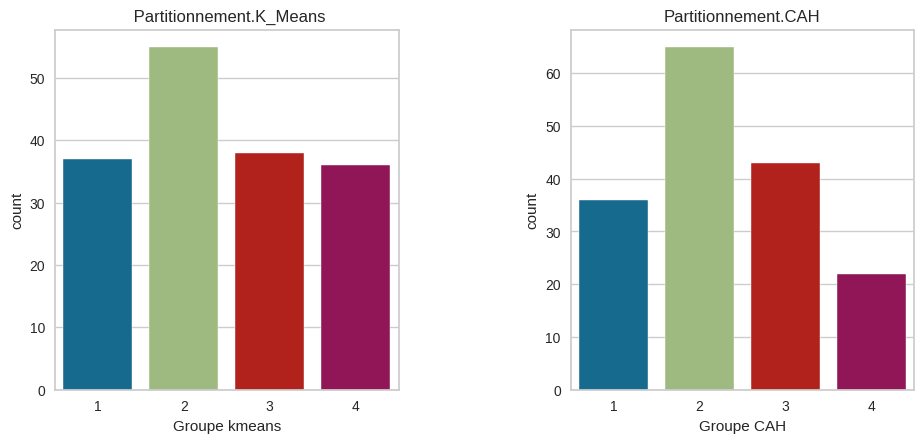

In [43]:

plt.figure(1,figsize=(10,12))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.5, wspace = 0.5, hspace = 0)
plt.subplot(1,3,1)
sns.countplot(
    x='Groupe kmeans', 
    data=df)
plt.title(' Partitionnement.K_Means')
plt.subplot(1,3,2)
sns.countplot(
    x='Groupe CAH', 
    data=dendro4)
plt.title('Partitionnement.CAH')

plt.show()

<ins>**Conclusion**</ins> 

Le partitionnement K.Means nous permet d'obtenir une répartition plus homogène. Nous choisissons donc de poursuivre l'étude sur un partitionnement Kmeans.

# **.Analyse des variables**

Avant de réaliser une ACP il faut vérifier qu'il existe une corrélation entre les variables. Pour se faire nous allons nous appuyer sur une heatmap. Mais avant toute chose vérifions si nos variables suivent une distribution normale afin de pouvoir adapter notre matrice.

## **. Verification de la distribution de nos variables**

In [44]:
from scipy.stats import anderson

variable1 = (anderson(df['nb_habitant'], dist='norm'))
variable2 = (anderson(df['Croiss.dem'], dist='norm'))
variable3 = (anderson(df['Import_Volaille'], dist='norm'))
variable4 = (anderson(df['TDI volaille (%)'], dist='norm'))
variable5 = (anderson(df['dispo animale'], dist='norm'))
variable6 = (anderson(df['dispo volaille'], dist='norm'))               
variable7 = (anderson(df['dispo Prot.animale'], dist='norm'))
variable8 = (anderson(df['pib_hab_US$'], dist='norm'))
variable9 = (anderson(df['Inflation (%)'], dist='norm'))
variable10 = (anderson(df['Stab_poltiq.'], dist='norm'))
                    

print(f"Critical values: {variable1[1]}")
print(f"Significance levels: {variable1[2]}")

print(f"A-D statistic for nb_habitant: {variable1[0]}")                  
print(f"A-D statistic for Croissance démographique : {variable2[0]}")                      
print(f"A-D statistic for Import_Volaille: {variable3[0]}")                   
print(f"A-D statistic for TDI volaille: {variable4[0]}")                   
print(f"A-D statistic for dispo alimentaire d’origine animale: {variable5[0]}")                   
print(f"A-D statistic for dispo volaille: {variable6[0]}")                    
print(f"A-D statistic for protéines d'origine animale: {variable7[0]}")                   
print(f"A-D statistic for PIB: {variable8[0]}")
print(f"A-D statistic for Inflation: {variable9[0]}")
print(f"A-D statistic for stabilite_politique: {variable10[0]}")


Critical values: [0.563 0.641 0.769 0.897 1.067]
Significance levels: [15.  10.   5.   2.5  1. ]
A-D statistic for nb_habitant: 23.051000446092445
A-D statistic for Croissance démographique : 2.6800960705048453
A-D statistic for Import_Volaille: 30.21200388994717
A-D statistic for TDI volaille: 7.967812073815111
A-D statistic for dispo alimentaire d’origine animale: 0.9803973105296677
A-D statistic for dispo volaille: 5.315989934698877
A-D statistic for protéines d'origine animale: 0.5018032532552752
A-D statistic for PIB: 17.415015636480916
A-D statistic for Inflation: 11.446361649042927
A-D statistic for stabilite_politique: 0.9325782618847711


Toutes les variables suivent une distribution normale, sauf la variables "protéine d'origine animale" .

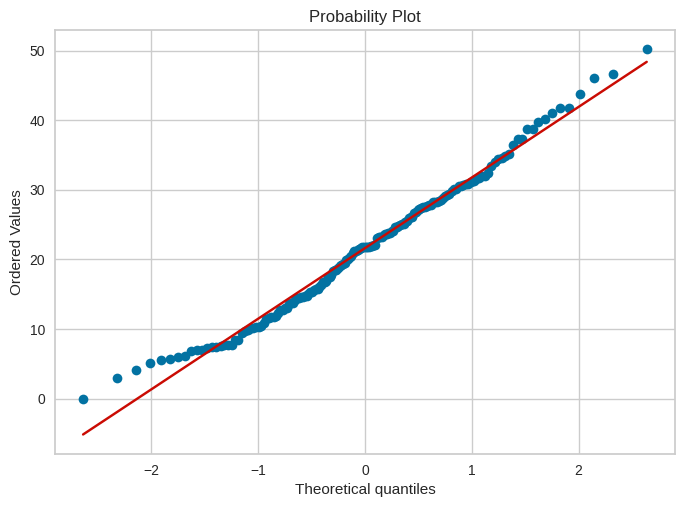

In [45]:
#visualisation graphique de la variable
import pylab
import scipy.stats as st
st.probplot(df["dispo Prot.animale"], dist="norm", plot=pylab)
pylab.show()

Léger décalage avec la distribution normale. Nous allons donc réaliser une matrice de corrélation basée sur le test non paramétrique de Spearman.

## **. Heatmap**

<ins>**Définition**</ins>:

La carte thermique est utilisée pour représenter graphiquement les valeurs de la matrice avec différentes nuances de couleurs pour différentes valeurs. Une matrice de corrélation est utilisée pour évaluer la dépendence entre plusieurs variables en même temps. La matrice indique comment les variables d’un ensemble de données sont liées les unes aux autres et comment elles se déplacent les unes par rapport aux autres.

 <ins>**Méthodologie**</ins>:
 
 La valeur de la corrélation va de -1 à +1. 0 La corrélation indique que deux variables sont indépendantes l’une de l’autre. Une corrélation positive indique que les variables évoluent dans le même sens, et une corrélation négative indique le contraire

In [46]:
df.columns

Index(['nb_habitant', 'Croiss.dem', 'Import_Volaille', 'TDI volaille (%)',
       'TAS volaille (%)', 'dispo animale', 'dispo volaille',
       'dispo Prot.animale', 'pib_hab_US$', 'Inflation (%)', 'Stab_poltiq.',
       'Groupe kmeans'],
      dtype='object')

In [47]:
cols=['nb_habitant', 'Croiss.dem', 'Import_Volaille', 'TDI volaille (%)',
       'TAS volaille (%)', 'dispo animale', 'dispo volaille',
       'dispo Prot.animale', 'pib_hab_US$', 'Inflation (%)', 'Stab_poltiq.']

In [48]:
df_heat=df[cols]

<AxesSubplot: >

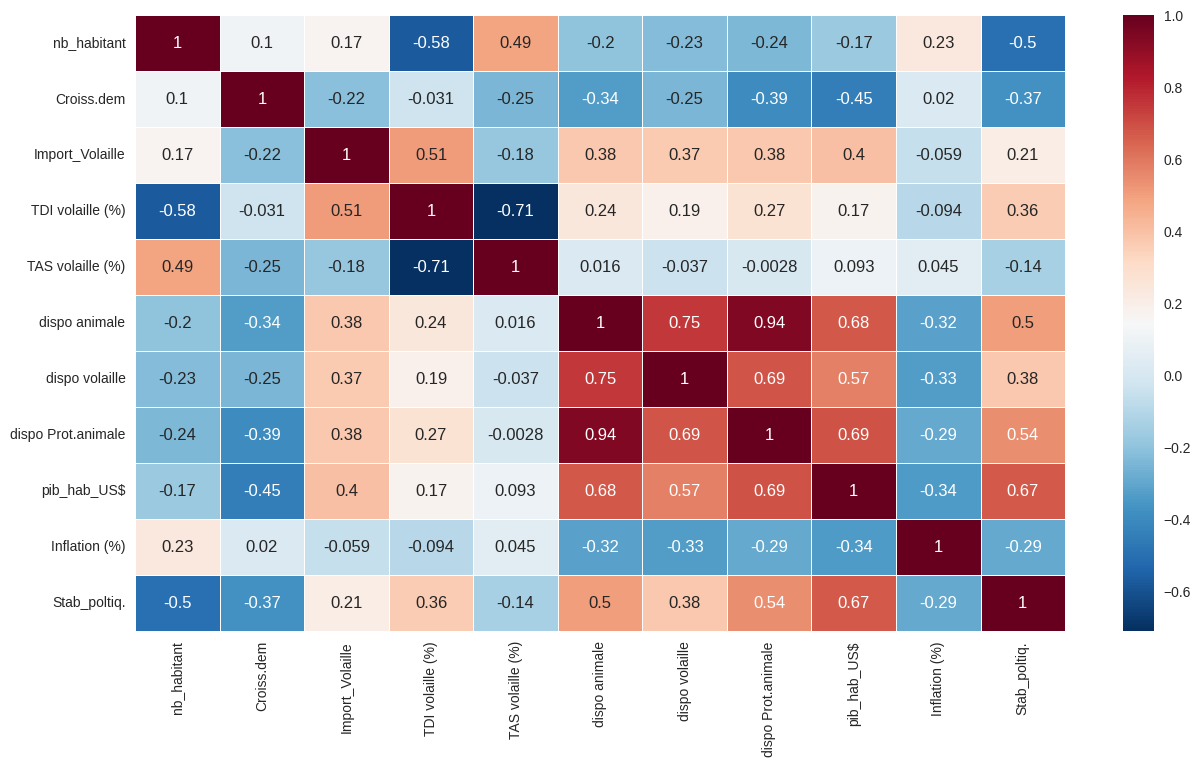

In [49]:
#Matrice des corrélations avec spearman
spearmancorr = df_heat.corr(method='spearman')
plt.figure(figsize = (15,8))
sns.heatmap(spearmancorr, xticklabels=spearmancorr.columns, yticklabels=spearmancorr.columns, cmap='RdBu_r', annot=True, 
linewidth=0.5)

Découpage en triangle de la matrice pour faciliter la lecture

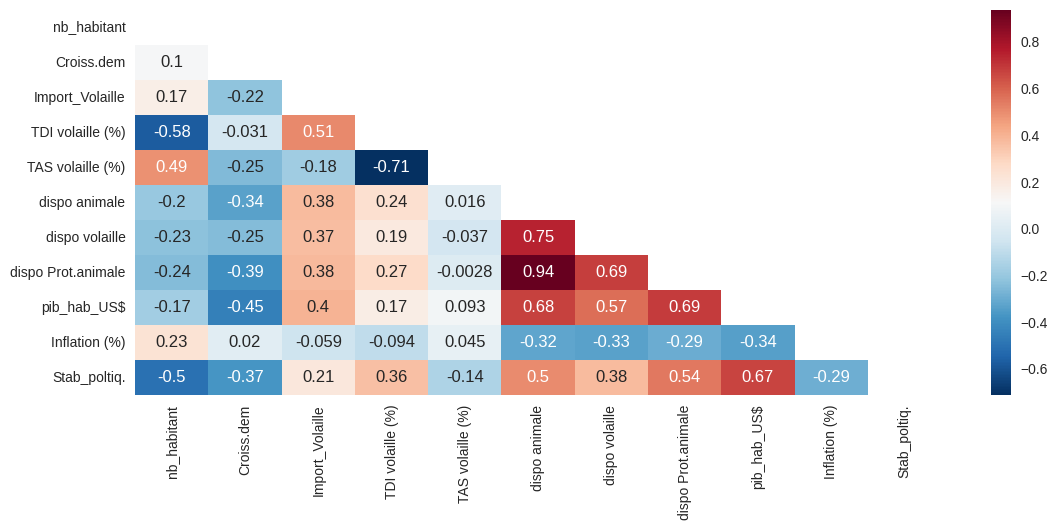

In [50]:
#Triangle des corrélations avec spearman

matrice = df_heat.corr(method="spearman")
mask = np.triu(np.ones_like(matrice, dtype=np.bool))
plt.figure(figsize=(13, 5))
sns.heatmap(matrice, mask=mask, annot=True, cmap='RdBu_r')
plt.show()

 <ins>**Interprétation**</ins>:

il semblerait ici que :

 * Les variables suivantes soient fortement corrélées positivement entre elles: 
   * dispo alimentaire animale - dispo alimentaire volaille - dispo en proteine
   * TDI volaille +import volaille
   * TAS volaille + nb habitant
   * PIB+Stabilité politique
   * TDI + stabilité politique
        
 * Les variabless suivantes sont moyennement corrélées positivement entre elles: 
   * Import_volaille + toutes les disponibilités 
   * TDI volaille + toutes les disponibilités
   * Import volaille + TDI volaille
   * TDI volaille + stabilité politique
   * Import volaille + stabilité politique
   * Import volaille + PIB
   * TDI + PIB
   * Inflation + nb d'habitant
   * Import de volaille + nb d'habitant
            
 * Les variabless suivantes sont fortement corrélées négativement: 
   * TDI volaille + TAS volaille
   * TDI volaille + nb habitant
   * Stabilité politique + nb d'habitant
   * nb habitant + inflation
   * croissance demo + dispo animales - dispo volaille et dispo proteines
   * Croissance demographique + TAS
   * Croissance demographique + import de volaille
   * Croissance démographique + PIB
   
 * Les variables suivantes ne sont pas ou trés peu corrélées:
  * TAS volaille + (inflation,Pib, toutes les dispo)
  * Inflation + croissance démographie
  * TDI + croissance démographique
        
 
        

# **. ACP**

<ins>**Définition:**</ins>

L'analyse en composantes principales (ACP) vise à réduire le nombre de variables appliquées à des individus, pour simplifier les observations tout en conservant un maximum d’informations. 

<ins>**Méthodologie:**</ins>

Il s’agit de résumer l’information qui est contenue dans une large base de données en un certain nombre de variables synthétiques appelées : Composantes principales. 

L’idée est ensuite de pouvoir projeter ces données sur l’hyperplan le plus proche afin d’avoir une représentation simple de nos données.
Évidemment, qui dit réduction de dimension dit perte d’informations. C’est là tout l’enjeu que représente une Analyse en Composantes principales. Il faut pouvoir réduire la dimension de nos données tout en conservant un maximum d’informations.

<ins>**Les étapes:**</ins> 
    
1) De la matrice de nos données centrées réduites nous allons calculer des valeurs propres et vecteurs propres (la notion de vecteur propre correspond à l’étude des axes privilégiés, selon lesquels une application d’un espace dans lui-même se comporte comme une dilatation, multipliant les vecteurs par une  constante appelée valeur propre. Les vecteurs auxquels il s’applique s’appellent vecteurs propres, réunis en un espace propre

2) Ces valeurs propres vont ensuite nous permettre de déterminer le nombre de facteur/Composantes principales optimal pour notre ACP. Nous choisirons ici a minima de garder une variance de 70% pour éviter de perdre trop d'informations.

3) Afin de visualiser l’importance de chaque variable explicative pour chaque axe de représentation nous utiliserons les cercles des corrélations afin de pouvoir comprendre ce qui détermine la structure de nos composantes principales

4) Nous pourrons alors représenter le cluster choisi sur ces axes et etudier l'influences des variables sur ceux ci ce qui nous permettra ensuite de pouvoir réaliser une selection des pays à cibler

## **. Composantes principales**

### **. Valeurs propres**

<ins>**Eboulis des valeurs propres**</ins>

<ins>**Definition**</ins>

Le rapport de variance expliqué est un ensemble important de nombres à comprendre dans l’ACP, et la façon la plus simple de les comprendre est de les tracer sur ce qu’on appelle un diagramme d’éboulis.

Les barres bleues montrent la variance en pourcentage expliquée par chaque composante principale (*cela vient de pca.explained_variance_ratio_). La ligne rouge montre la somme cumulée (**cela vient de pca.explained_variance_ratio_.cumsum())

les diagrammes d’éboulis peuvent être utilisés pour visualiser et déterminer le nombre de composants principaux que nous souhaitons conserver lorsque vous passez à une analyse plus approfondie des données.

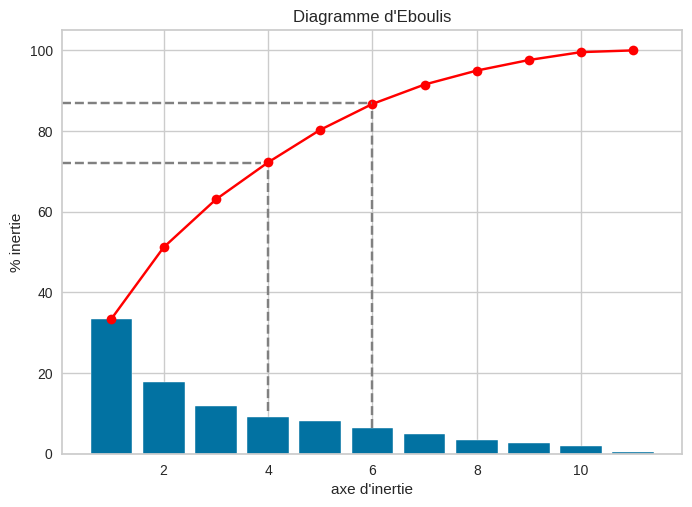

In [51]:
#Diagramme d'eboulis 
pca = decomposition.PCA()
pca.fit(X_scaled)
scree = pca.explained_variance_ratio_*100

plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    
plt.xlabel("axe d'inertie")
plt.ylabel("% inertie")
plt.axhline(y=72, xmin=0, xmax=0.32, ls='--',color ="grey")
plt.axhline(y=87, xmin=0, xmax=0.50, ls='--',color ="grey")
plt.axvline(x=4, ymin=0.1, ymax=0.67, ls='--',color ="grey")
plt.axvline(x=6, ymin=0.06, ymax=0.81, ls='--',color ="grey")
plt.title("Diagramme d'Eboulis")
plt.show(block=False)

* *Ratio de variance expliqué*

*Il s’agit d’un tableau de la variance des données expliquée par chacune des 10 composantes principales, en commençant par PC1, la composante principale qui explique la majeure partie de la variance*

In [52]:
pca.explained_variance_ratio_

array([0.33466049, 0.17710023, 0.11862771, 0.09189025, 0.08073542,
       0.06417661, 0.0481892 , 0.03458319, 0.02619867, 0.01955787,
       0.00428036])

* *Ratio de variance cumulée*

In [53]:
pca.explained_variance_ratio_.cumsum()

array([0.33466049, 0.51176072, 0.63038843, 0.72227868, 0.8030141 ,
       0.86719071, 0.91537991, 0.9499631 , 0.97616177, 0.99571964,
       1.        ])

</ins>**Interprétation**</ins>

* Pour 2 composantes nous aurions une variance d'environs 51% *(F1+F2 expliquent 51% de la variance dans les données originales)*
* Pour 4 composantes nous aurions une variance d'environs 72% *(F1+F2+F3+F4 expliquent 72% de la variance dans les données originales)*
* Pour 6 composantes nous aurionsons une variance d'environs 86% *(F1+F2+F3+F4+F5+F6 expliquent 86% de la variance dans les données originales)*

Représentons le diagramme Eboulis pour 4 et 6. Nous excluons la combinaison de 2 composantes car la perte d'information serait trop importante (environs 50% de perte)

<ins>**Taux de variance cumulative**</ins>

**Pour 4 composantes**

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [11] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[4]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


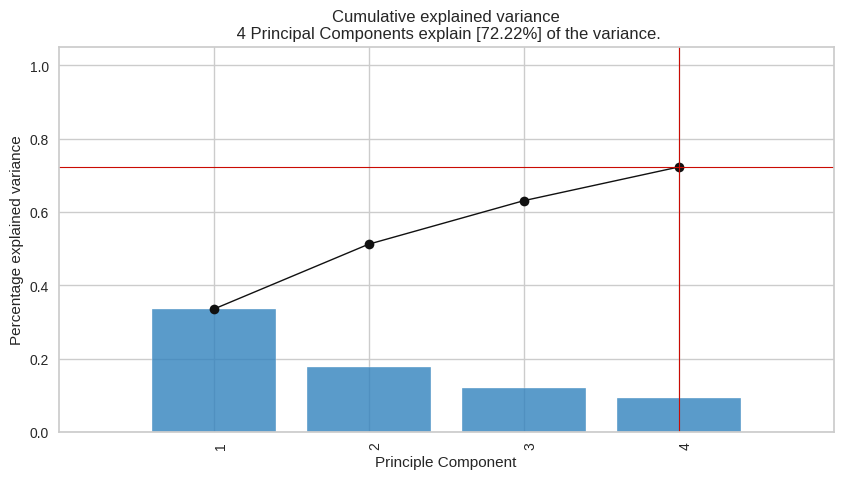

<Figure size 800x550 with 0 Axes>

In [54]:
from pca import pca
model = pca(n_components=4)
results = model.fit_transform(X_scaled)
fig, ax = model.plot(figsize=(10, 5))
plt.show()

**Pour 6 composantes**

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [11] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[6]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


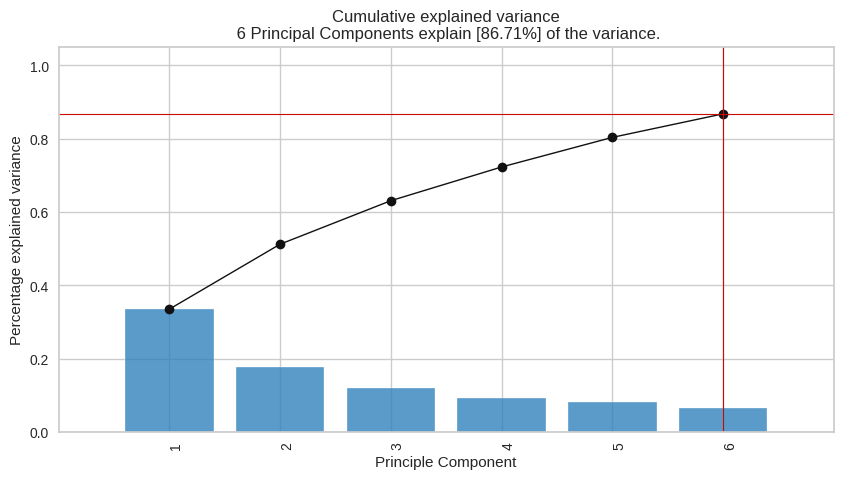

<Figure size 800x550 with 0 Axes>

In [55]:
from pca import pca
model = pca(n_components=6)
results = model.fit_transform(X_scaled)
fig, ax = model.plot(figsize=(10, 5))
plt.show()



Le taux de 72% nous semble correcte mais pour choisir entre 4 et 6 composantes étudions de plus près la composition de chacune de celles ci

### **. Analyse des composantes principales**

####  <ins>**Tableau des scores des composantes**</ins>

Chaque composante dispose d'un 'score' pour chaque variable. Le score montre dans quelle mesure la variable influence la composante principale. + le score est élevé plus l'influence de la variable sur la composante est importante.

Représentons ce tableau pour nos 6 composantes

In [56]:
n_components = 6 #on définit le nombre de composantes
pca = PCA(n_components=n_components) #On instancie notre ACP 
pca.fit(X_scaled) #On l'entraine sur les données scalées 
pcs = pca.components_ #calcul des composantes
pcs

array([[-1.23798303e-01, -1.60418586e-01,  1.55838345e-01,
         2.15443802e-01, -1.11618197e-01,  4.66425448e-01,
         3.74127969e-01,  4.63585450e-01,  3.18482197e-01,
        -2.37571543e-01,  3.81408654e-01],
       [ 4.01062078e-01, -3.26636328e-01,  6.26364412e-02,
        -5.39012053e-01,  6.12533322e-01,  1.32892421e-01,
         5.59564619e-02,  1.41022170e-01,  1.35068003e-01,
        -1.55252350e-02, -6.03353911e-02],
       [ 5.17707970e-01,  3.22016862e-01,  6.40476659e-01,
         1.55141244e-01, -1.67746464e-01,  1.13704246e-01,
         1.55321785e-01,  3.41863272e-02, -1.00130848e-02,
         1.65280140e-01, -3.16584209e-01],
       [ 9.71159648e-02,  5.19880844e-02,  3.18541097e-01,
         5.84155240e-02,  3.97846631e-02, -2.74430678e-01,
        -4.66527242e-01, -2.43002734e-01,  5.52278710e-01,
        -3.64942142e-01,  3.01989025e-01],
       [ 6.98882594e-06,  6.22215260e-01, -2.11859859e-01,
        -2.49093617e-01,  8.01560303e-02,  5.44023847e-02,
  

In [57]:
pcs = pd.DataFrame(pcs) #calcul des composantes version pandas
pcs

0         1         2         3         4         5         6   \
0 -0.123798 -0.160419  0.155838  0.215444 -0.111618  0.466425  0.374128   
1  0.401062 -0.326636  0.062636 -0.539012  0.612533  0.132892  0.055956   
2  0.517708  0.322017  0.640477  0.155141 -0.167746  0.113704  0.155322   
3  0.097116  0.051988  0.318541  0.058416  0.039785 -0.274431 -0.466527   
4  0.000007  0.622215 -0.211860 -0.249094  0.080156  0.054402  0.259421   
5 -0.049952  0.494038 -0.245059 -0.174600  0.051188  0.063648  0.030555   

         7         8         9         10  
0  0.463585  0.318482 -0.237572  0.381409  
1  0.141022  0.135068 -0.015525 -0.060335  
2  0.034186 -0.010013  0.165280 -0.316584  
3 -0.243003  0.552279 -0.364942  0.301989  
4 -0.030950 -0.022886 -0.636928 -0.148571  
5  0.069234  0.517837  0.598860  0.153967

In [58]:
x_list = range(1, n_components+1) #on definit une variable avec la liste de nos composantes
list(x_list)

[1, 2, 3, 4, 5, 6]

In [59]:
#Table des corrélations entre les variables et les 6 composantes.
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

nb_habitant  Croiss.dem  Import_Volaille  TDI volaille (%)  \
F1        -0.12       -0.16             0.16              0.22   
F2         0.40       -0.33             0.06             -0.54   
F3         0.52        0.32             0.64              0.16   
F4         0.10        0.05             0.32              0.06   
F5         0.00        0.62            -0.21             -0.25   
F6        -0.05        0.49            -0.25             -0.17   

    TAS volaille (%)  dispo animale  dispo volaille  dispo Prot.animale  \
F1             -0.11           0.47            0.37                0.46   
F2              0.61           0.13            0.06                0.14   
F3             -0.17           0.11            0.16                0.03   
F4              0.04          -0.27           -0.47               -0.24   
F5              0.08           0.05            0.26               -0.03   
F6              0.05           0.06            0.03                0.07   

    pib_hab_US$  Inflation (%)  Stab_poltiq.  
F1         0.32          -0.24          0.38  
F2         0.14          -0.02         -0.06  
F3        -0.01           0.17         -0.32  
F4         0.55          -0.36          0.30  
F5        -0.02          -0.64         -0.15  
F6         0.52           0.60          0.15

In [60]:
#Pivot du tableau pour faciliter la lecture
pcs.T

F1        F2        F3        F4        F5        F6
nb_habitant        -0.123798  0.401062  0.517708  0.097116  0.000007 -0.049952
Croiss.dem         -0.160419 -0.326636  0.322017  0.051988  0.622215  0.494038
Import_Volaille     0.155838  0.062636  0.640477  0.318541 -0.211860 -0.245059
TDI volaille (%)    0.215444 -0.539012  0.155141  0.058416 -0.249094 -0.174600
TAS volaille (%)   -0.111618  0.612533 -0.167746  0.039785  0.080156  0.051188
dispo animale       0.466425  0.132892  0.113704 -0.274431  0.054402  0.063648
dispo volaille      0.374128  0.055956  0.155322 -0.466527  0.259421  0.030555
dispo Prot.animale  0.463585  0.141022  0.034186 -0.243003 -0.030950  0.069234
pib_hab_US$         0.318482  0.135068 -0.010013  0.552279 -0.022886  0.517837
Inflation (%)      -0.237572 -0.015525  0.165280 -0.364942 -0.636928  0.598860
Stab_poltiq.        0.381409 -0.060335 -0.316584  0.301989 -0.148571  0.153967

<AxesSubplot: >

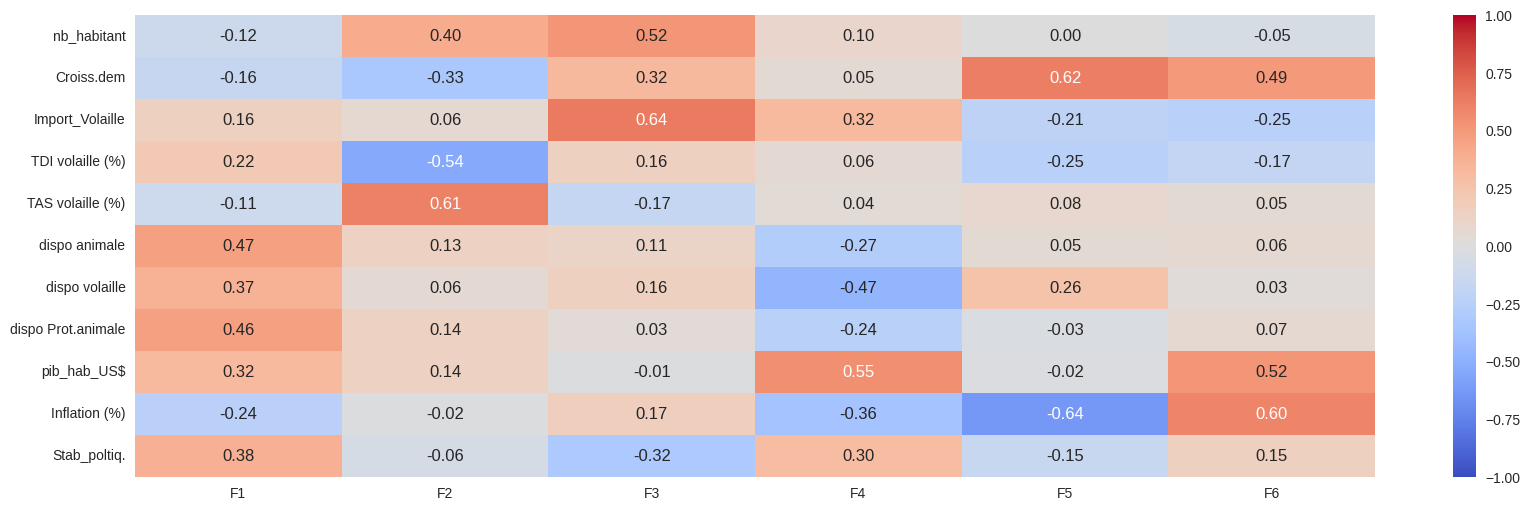

In [61]:
#heatmap entre les variables et les 6 composantes
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

 <ins>**Interprétation**</ins>:

il semblerait ici que pour :
* **F1** les variables suivantes lui soient fortement corrélées:

    * Toutes les disponibilités, le Pib et la stabilité poltique (positivement)
    * Inflation (négativement)
    
* **F2** les variables suivantes lui soient fortement corrélées:

    * TAS volaille et Nombre d'habitant (positivement) 
    * TDI volaille et croissance démographique (négativement)
        
* **F3** les variables suivantes lui soient fortement corrélées:

    * Import de volaille, Croissance démographique et nombre d'habitant (positivement)
    * Stabilité politique (négativement)

    
* **F4** les variables suivantes lui soient fortement corrélées:

    * PIB,Stabilité politique et import de volaille (positivement)
    * Toutes les disponibilité (négativement) 
    
* **F5** les variables suivantes lui soient fortement corrélées:

    * Inflation (négativement) et croissance démographique (positivement)
    
* **F6** les variables suivantes lui soient fortement corrélées:

    * Inflation, Pib et Croissance démographique (positivement)
    * Import de volaille (négativement)

        


Vérifions cette première interprétation de la heatmap avec les cercles de corrélation . En effet les cercles de corrélations nous permettrons d'identifier les variables les mieux représentés et celles qui le sont moins afin de mieux comprendre les mécanismes mis en avant par les différentes composantes et statuer sur notre choix de composantes


####  <ins>**Cercles de corrélation**</ins> 

<ins>**Principe**</ins>

Nous pouvons tracer ces scores de composantes sur un tableau de cercle de corrélation (parfois appelé carte factorielle des variables) pour les rendre plus faciles à digérer. Chaque tracé est dessiné sur un plan factoriel, c’est-à-dire l’espace vectoriel constitué de l’intersection de deux des composantes principales

<ins>**Fonctionnement**</ins>

Nous avons un cercle de rayon 1. L’axe horizontal représente la composante principale 1. L’axe vertical représente la composante principale 2. À l’intérieur du cercle, nous avons des flèches pointant dans des directions particulières. Certaines flèches sont plus longues que d’autres.

 * La longueur des flèches représente dans quelle mesure cette variable explique la variance des données sur le plan factoriel. 

 * L’angle entre les variables fournit une indication de la façon dont les variables sont corrélées sur le plan factoriel.Plus une flèche est longue plus elle est bien représentée et interprétable, plus elle est courte et plus elle est mal représentée et donc difficile à interpréter

  * Un petit angle indique que la représentation des deux variables sur le plan factoriel est positivement corrélée. 

  * Un angle de 90 degrés indique qu’il n’y a pas de corrélation. 

  * Un angle de 180 degrés indique une corrélation négative. 

  * A noter que l’angle entre les lignes ne vous donne pas une mesure de la corrélation entre les variables d’origine. Les données ont été projetées sur ce plan factoriel. Ainsi, nous ne voyons vraiment qu’une mesure de corrélation sur le plan factoriel, pas dans les données originales.C'est la matrice de corrélation vu précédemment qui permet de déterminer les corrélations entre les variables d'origine.

In [62]:
#on crée une fonction pour définir nos cercles
def correlation_graph(pca, 
                      x_y, 
                      features) : 
      # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(8, 8))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.03,
                head_length=0.03, 
                width=0.01,
                color = "g")

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='silver', ls='--')
    plt.plot([0, 0], [-1, 1], color='silver', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an),color='b',linewidth=1)  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

<ins>**Cercle des corrélations F1 F2**</ins>

In [63]:
x_y = (0,1)
x_y

(0, 1)

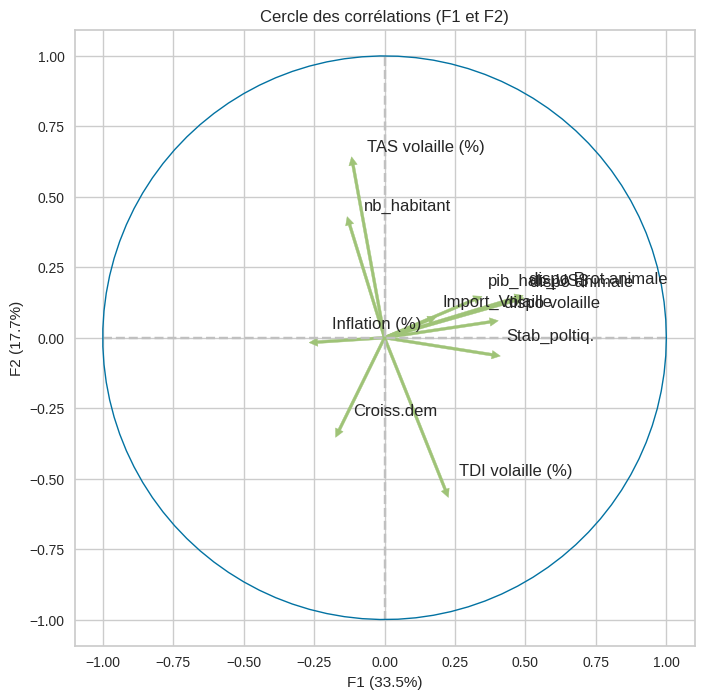

In [64]:
correlation_graph(pca, x_y, features)

<ins>**Observations du Cercle des corrélations F1 F2**</ins>

Analyse selon la longueur des flèches:

 * L'import de volaille est trés faiblement corrélées à F1 et F2 (petite flèches). Cette variable n'entre donc pas dans l'étude du cercle de corrélation car trés faiblement représentée.

Analyse selon l'angle:

 * Les variables les plus corrélées positivement à F1 sont : toutes les disponibilités alimentaires + stabilité politique
 * Les variables les plus corrélées négativement à F1 sont : L'inflation
    
 * Les variables les plus corrélées positivement à F2 sont : TAS volaille + nb d'habitant
 * Les variables les plus corrélées négativement à F2 sont : TDI volaille + croissance démographique   
    

<ins>**Interprétation du Cercle des corrélations F1 F2**</ins>:
    
**Il semblerait que la composante F1 mette en avant les mécanismes suivant:**
 * Lorsque le Pib et la stabilité politique sont favorables (évoluent positivement), toutes les disponibilité évoluement positivement.
(Nous avons en effet vu précemment dans la heatmap que ces variables étaient fortement corrélées entre elles.)
 * Lorsque L'inflation augmentent les disponibilité s'amenuisent 
( d'après la heatmap inflation et disponibilité sont corrélés négativement)

**Il semblerait que la composante F2 mette en avant les mécanismes suivant:**
 * Le TDI et le TAS évoluent en sens opposées. En effet si le TAS est important c'est à dire si la production de volaille est importante le recours à l'importation s'en voit diminué.
 
 * Lorsque les pays subissent une baisse de la croissance démographique ceux ci auraient tendance à avoir davantage recours à l’importation plutôt qu’à la production. On peut supposer que face à une démographie qui progresse rapidement il est plus efficient et rapide d’avoir recours à l’importation plutôt que d’adapter ses moyens de production qui peuvent être plus long à mettre en place pour répondre à la demande interne grandissante.
 
 * A contrario lorsque le nb d’habitant augmente le TAS augmente et le TDI baisse. On peut supposer qu’au sein des pays ayant un nombre d’habitant important, le recours à la production interne est privilégié par rapport au recours à l’importation surtout si la croissance démographique n’évolue pas trop rapidement. Ce qui semble se confirmer ici puisqu’on peut remarquer que croissance démographique et nombre d’habitant évoluent en sens inverse.


<ins>**Cercle des corrélations F3 F4**</ins>

In [65]:
x_y = (2,3)
x_y

(2, 3)

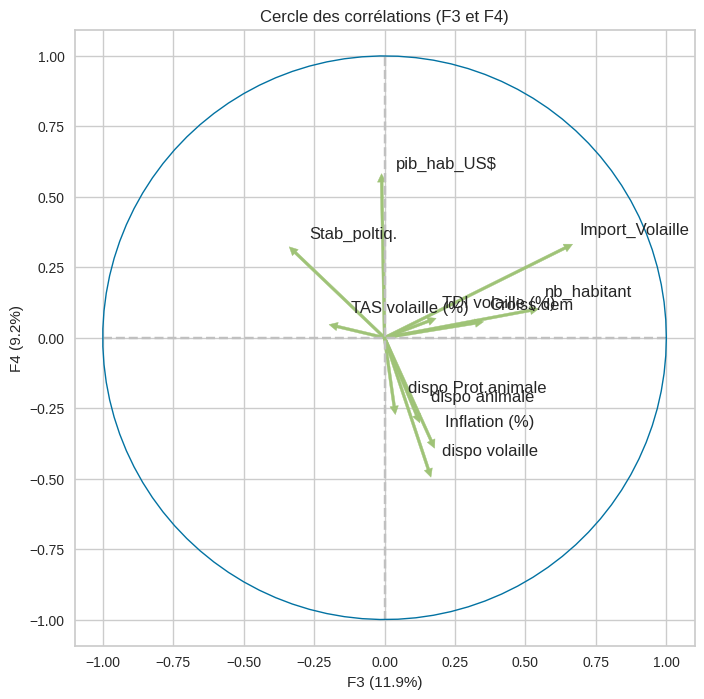

In [66]:
correlation_graph(pca, x_y, features)

<ins>**Observations du Cercle des corrélations F3 F4**</ins>

Analyse selon la longueur des flèches:

 * le TAS,TDI sont trés faiblement corrélées à F3 et F4 (petite flèches). Ces 2 variables n'entrent donc pas dans l'étude du cercle de corrélation car trés faiblement représentées.

Analyse selon l'angle:

 * Les variables les plus corrélées positivement à F3 sont : Import volaille, nb d'habitant et croissance démographique
 * Les variables les plus corrélées négativement à F3 sont : Stabilité politique 
    
 * Les variables les plus corrélées positivement à F4 sont : PIB et stabilité politique et l'import de volaille
 * Les variables les plus corrélées négativement à F4 sont : Toutes les disponibilités et inflation


<ins>**Interprétation du Cercle des corrélations F3 F4**</ins>:

**Il semblerait que la composante F3 mette en avant les mécanismes suivant:**
* Lorsque la croissance démographique et le nombre d'habitant augmente le pays importe davantage de volaille.
* Lorsqu'il y a instabilité politique le nombre d'habitant, la croissance démographique et l'import de volaille baisse. Donc un pays qui subit une forte instabilité politique aura tendance à moins importer de volaille en quantité et verra sa démographie diminuer.

**Il semblerait que la composante F4 mette en avant les mécanismes suivant:**
* F3 nous propose une lecture inversée à celle de F4 et confirme ce que nous avons pu voir précédemment en incluant en plus l'impact du PIB.En effet ici F4 nous indique que lorsque le Pib et la stabilité politique sont favorables (évoluent positivement) le pays importe davantage de volaille
* On remarque également que plus l'inflation augmente plus les disponibilités augmentent. Ce qui indique que l'augmentation des prix freine la consommation et donc les disponibilités sont plus importantes.


<ins>**Cercle des corrélations F5 F6**</ins>

In [67]:
x_y = (4,5)
x_y

(4, 5)

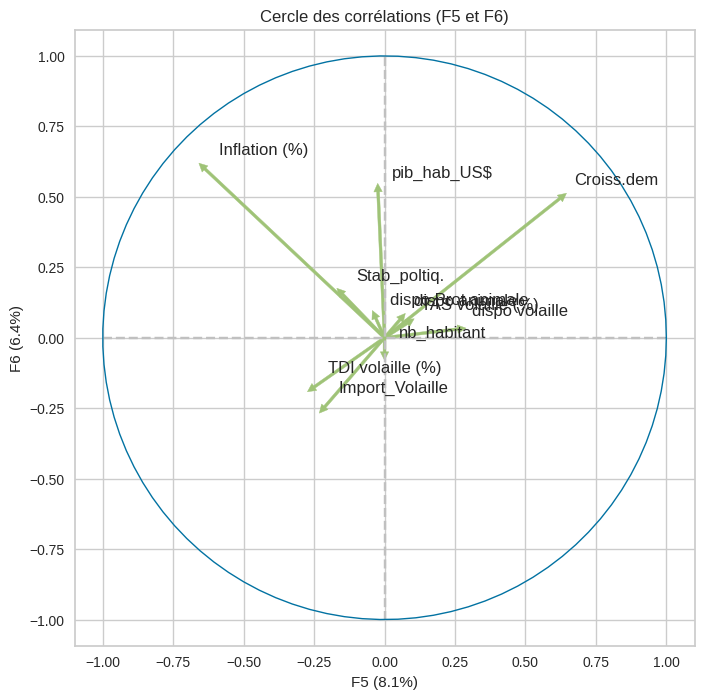

In [68]:
correlation_graph(pca, x_y, features)

croissance démographique lié à tdi et import volaille
croissance démographiquehique augmente inflation baisse

<ins>**Observations du Cercle des corrélations F5 F6**</ins>

Analyse selon la longueur des flèches:

 * Dispo volaille, dispo animale,proteine animalee, stabilité politique, nb d'habitant sont trés faiblement corrélées à F3 et F4 (petite flèches)

Analyse selon l'angle:

 * Les variables les plus corrélées positivement à F5 sont : croissance démographique 
 * Les variables les plus corrélées négativement à F5 sont : L'inflation
    
 * Les variables les plus corrélées positivement à F6 sont : PIB,Inflation, croissande dem 
 * Les variables les plus corrélées négativement à F6 sont : TDI volaille et import de volaille

<ins>**Interprétation du Cercle des corrélations F5 F6**</ins>:

**Il semblerait que la composante F5 mette en avant le mécanisme suivant:**
* Sur sa partie droite l'évolution de la croissance démographique et la dispo en volaille
* Sur sa partie gauche l'évolution de l'inflation
Nous avons pu voir précédemment dans la heatmap que ces 2 variables n'étaient pas corrélées.Il n'y aurait donc pas de lien entre ces 2 variables.

**Il semblerait que la composante F6 mette en avant le mécanisme suivant:** 

* Lorsque la croissance démographique augmente l'inflation et le Pib augmente. En effet on peut supposer que plus une population augmente plus la consommation et donc la demande augmente ce qui a un impacte sur l'indice des prix si l'offre n'est pas suffisante.
* Lorsque la croissance démographique augmente le recours à l'importation baisse (TDI et import volaille). Comme vu sur F4 F5. 

####  <ins>**Choix du nombre de composante**</ins> 

Nous avons pu remarquer que les cercles F1-F2 et F3-F4 nous apportaient beaucoup d'informations concernant l'impact des variables sur la consommation, l'economie et le recours à l'import ou à la production de viande de volaille.
A contrario le cercle F5 et F6 représentent davantage l'impact des variables economiques et démographiques si ce n'est une information concernant l'impact de la croissance démographique sur le TDI et l'import de volaille.
Nouss choisissons donc de poursuivre l'étude sur les 4 premières composantes principales qui nous permettent d'avonsoir suffisamment d'information pour caractériser nos clusters

Grâce à l'ACP nous avons pu donc réduire notre nombre de variables de 11 à 4 en minimisant la perte d'information mais nous disposons également de 2 plans factoriels nous permettant d'étudier le positionnement de nos clusters en fonction de nos composantes principales.

# **. Projection**

## **. Méthodologie**

Nous pouvons voir les axes principaux d’inertie comme des « nouvelles variables » qui synthétisent des variables déjà existantes. Ainsi, F1 peut être vue comme une nouvelle variable que l’on ajoute sous forme de nouvelle colonne à notre Dataframe.


**Interprétation du positionnement des Pays sur les axes**

* Quand on se déplace le long de l’axe des abscisses de gauche à droite, c’est-à-dire dans le sens des abscisses croissantes, alors on se déplace vers les points pour lesquels la valeur de F(n) est grande.

Comme F(n) est très corrélée à certaines variables, alors il y a de grandes chances pour que ces individus aient aussi de grandes valeurs pour ces variables si les individus sont bien représentés.

* De même, on considère que les variables qui sont anticorrélée à F(n), sont les variables qui suivent la flèche qui pointe vers les abscisses décroissantes sur le cercle des corrélations. Ainsi, se déplacer dans le sens des abscisses croissantes signifie se déplacer vers les individus ayant de faibles valeurs pour la variable progression

**Qualité de la représentation des Pays sur les axes**

De même que nous avons pu le voir précédemment nous avions des variables (des flèches) bien ou mal représentées, nous avons ici aussi des Pays bien et mal représentés.

La qualité de sa représentation est lié à la proximité du point avec le plan factoriel.

**Proximité entre les individus**

Deux individus qui sont proches dans le plan ont de fortes similitudes, et s’ils sont éloignés, ils sont différents.Analyser les distances entre 2 points sur un plan factoriel n’est pertinent que si ces individus sont bien représentés tous les 2.


Comme vu précédemment notre choix s'oriente vers un partitionnement K_Means.
Représentons nos clusters sur nos 2 plans factoriels.

## **. Projection sur les plans factoriels**

### **. Projection des clusters avec centroïdes**

In [69]:
X_projected = pca.transform(X_scaled)

In [70]:
# Affichage sur plusieurs plans factoriels avec inertie des axes.
def plot_plans_factoriels(X_projected, n_components, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None, centroid=None):
    for d1,d2 in axis_ranks:
        if d2 < n_components:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(5,5))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Affichage des positions des centres de classes
            if centroid is not None:
                centroids = kmeans.cluster_centers_
                centroids_projected = pca.transform(centroids)
                for j,(x1,y1) in enumerate(centroids_projected[:,[d1,d2]]):
                    plt.scatter(x1,y1, c = 'black', marker='x', s=100, label="Centroides")
            
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des {} Pays sur F{} et F{}".format(X_projected.shape[0], d1+1, d2+1), fontsize=10)
            plt.show(block=False)

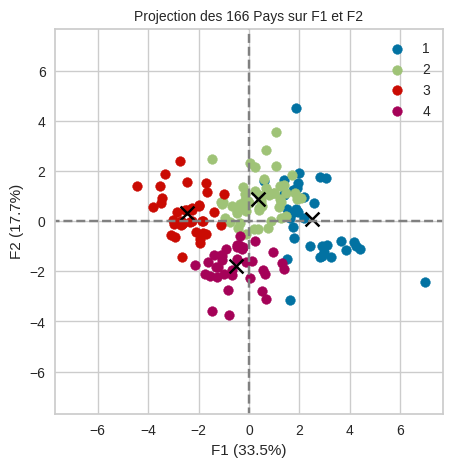

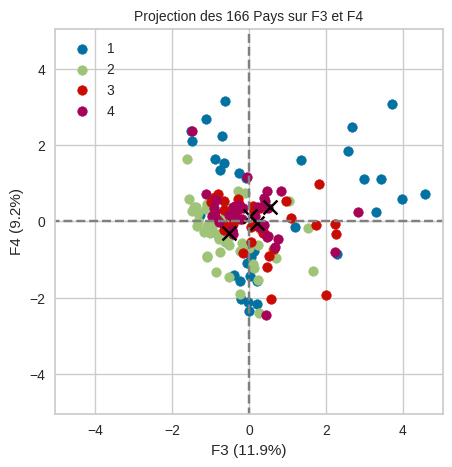

In [71]:
plot_plans_factoriels(X_projected, 4, pca, [(0,1),(2,3)], illustrative_var =Kmeans_clust , centroid=1)

### **. Analyse des clusters**

#### **. Analyse de la projection avec cercles de corrélation**

In [72]:
#on modifie la taille des cercles de corrélation
#on crée une fonction pour définir nos cercles
def correlation_graph(pca, 
                      x_y, 
                      features) : 
      # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(5, 5))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.03,
                head_length=0.03, 
                width=0.01,
                color = "g")

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='silver', ls='--')
    plt.plot([0, 0], [-1, 1], color='silver', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an),color='b',linewidth=1)  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

**Projection des 2 figures sur le premier plan factoriel**

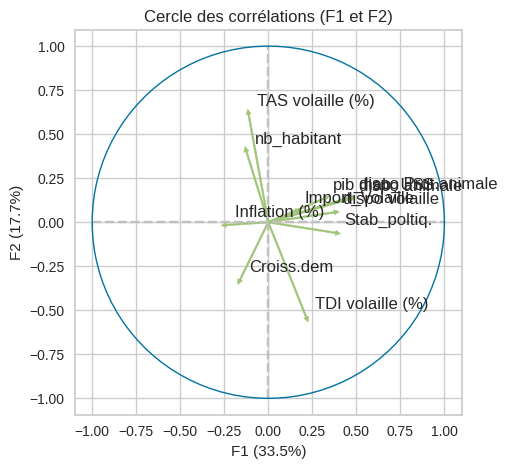

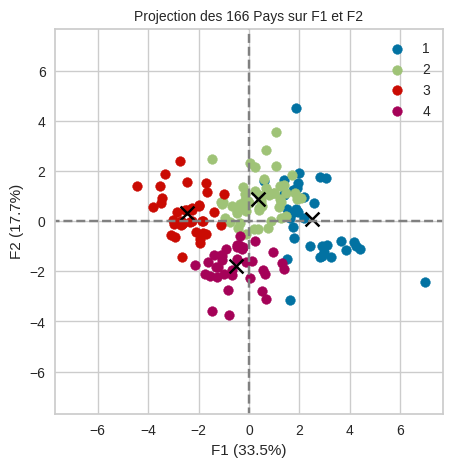

In [73]:
x_y = (0,1)
correlation_graph(pca, x_y, features)
plot_plans_factoriels(X_projected, 4, pca, [(0,1)], illustrative_var =Kmeans_clust , centroid=1)

La comparaison entre le cercle de corrélation et la projection des clusters sur les 2 composantes nous apprend les points suivants:

* **Le cluster n° 1 est caractérisé par** : la plus forte disponibilité alimentaire de tous les groupes , la meilleure stabilité politique,le Pib le plus élevé. 2ème TDI le plus élevé , le TAS et le nb d'habitant sont moyens. 3 Pays dans ce cluster se démarquent du groupe avec pour l'un un nombre d'habitant et un TAS élevé et un TDI trés faible, pour l'autre il s'agirait du pays qui disposerait de la meilleure stabilité plitique, des plus grosses disponibilités et meilleur PIB .

* **Le cluster n°2 est caractérisé par** :le groupe ayant la 2ème plus importante disponibilité alimentaire, ce serait également le 2ème après le groupe 1 en ce qui concerne la stabilité politique et le PIB, ce serait le cluster avec le TAS moyen le plus élevé. Le centroide étant peu éloigné de l'axe TDI moyen,idem pour le nb d'habitant

* **Le cluster n°3 est caractérisé par** le groupe qui dispose des disponibilités les plus faibles , la stabilité politique la plus dégradée,le TAS et le Nb d'habitant les plus élevés, Pib le plus faible , TDI faible.

* **le cluster n°4 est caractérisé par** le 2eme groupe qui dispose des plus faibles disponibilités, le centroîde est proche du centre donc stabilité politique quasi nulle,2eme Pib le moins important après le groupe 3, nombre d'habitant le plus faible,TAS le plus faible, TDI le plus élevé

Les clusters 1 et 4 sont préselectionnés sur la base d'un TAS faible et de variables politico economique plus favorables que les 2 autres groupes.La croissance démographique, l'inflation et l'import de volaille étant peu représenté sur ce plan factoriel nous ne pouvons évaluer le positionnement des clusters sur ces variables. Complétons l'analyse de ces variables avec le second cercle sur les groupes 1 et 4.




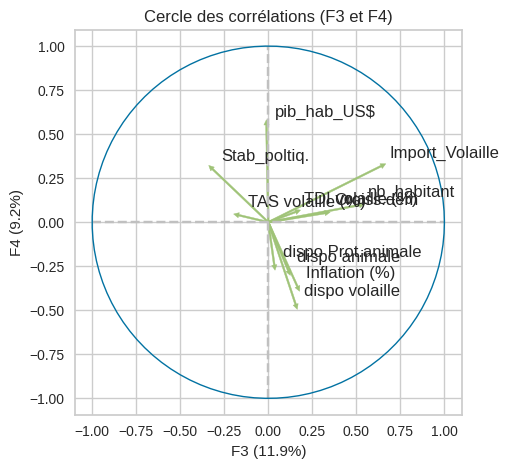

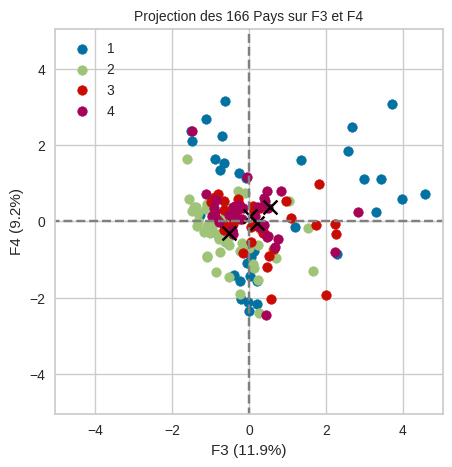

In [74]:
x_y = (2,3)
correlation_graph(pca, x_y, features)
plot_plans_factoriels(X_projected, 4, pca, [(2,3)], illustrative_var =Kmeans_clust , centroid=1)

* 1ere croix a droite : groupe 1 bleu
* 2eme croix a droite : groupe 4 violet
* 3eme croix au centre :groupe 3 rouge
* 4eme croix à gauche : groupe 2 vert

le 2 eme cercle de corréltion permet de selctionné le groupe n°1 qui dispose d'une meilleur stabilité politique, d'un bon pib, d'un nombre important d'habitant et qui importe le plus de volaille par rapport au groupe 4. Sélection du groupe 1.


#### **. Analyse des distributions moyennes**

L'analyse des moyennes de distribution des variables par groupes nous permettra de vérifier la précédente interprétation de la projection sur les plans factoriels

In [75]:
#On affiche la moyenne des groupes
df_clusters_kmeans_moy= df.groupby(['Groupe kmeans']).mean().round(2)
df_clusters_kmeans_moy.head()


nb_habitant  Croiss.dem  Import_Volaille  TDI volaille (%)  \
Groupe kmeans                                                               
1                    27.81       26.80           212.86             66.00   
2                    22.91       13.12            53.98             21.58   
3                    52.23       44.15            16.66              7.41   
4                     5.94       38.54            61.44             94.48   

               TAS volaille (%)  dispo animale  dispo volaille  \
Groupe kmeans                                                    
1                         55.57          11.58            5.31   
2                        104.34           8.50            3.41   
3                         92.99           3.43            0.95   
4                         21.35           4.92            1.95   

               dispo Prot.animale  pib_hab_US$  Inflation (%)  Stab_poltiq.  
Groupe kmeans                                                                
1                           32.10     39245.40           1.34          0.67  
2                           25.43     11392.96           3.15          0.13  
3                           10.71      2195.92           8.99         -0.93  
4                           16.55      4542.83           5.06         -0.00

**Pie chart moyenne par groupe par variable**

array([[<AxesSubplot: ylabel='nb_habitant'>,
        <AxesSubplot: ylabel='Croiss.dem'>,
        <AxesSubplot: ylabel='Import_Volaille'>],
       [<AxesSubplot: ylabel='TDI volaille (%)'>,
        <AxesSubplot: ylabel='TAS volaille (%)'>,
        <AxesSubplot: ylabel='dispo animale'>],
       [<AxesSubplot: ylabel='dispo volaille'>,
        <AxesSubplot: ylabel='dispo Prot.animale'>,
        <AxesSubplot: ylabel='pib_hab_US$'>],
       [<AxesSubplot: ylabel='Inflation (%)'>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

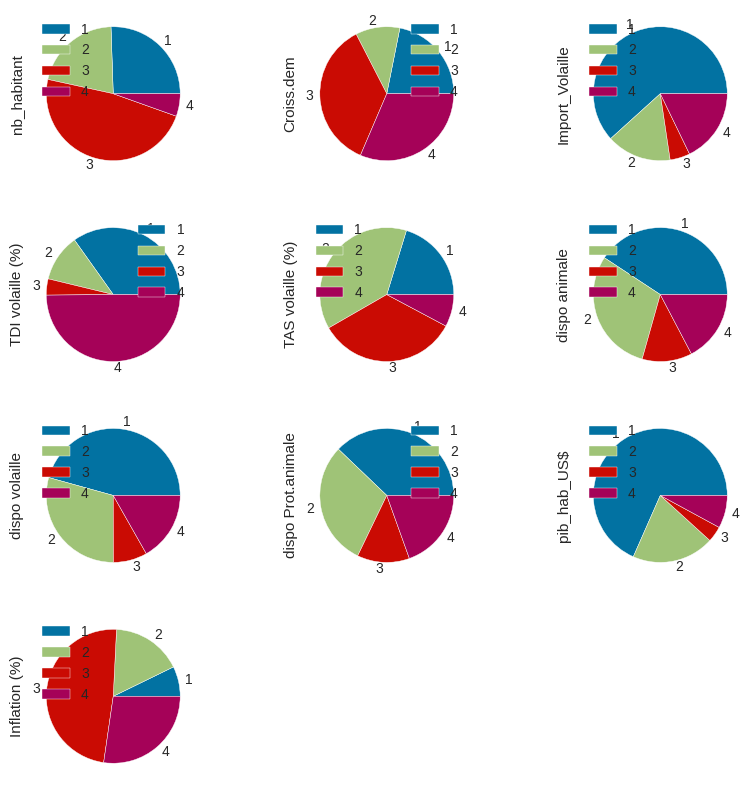

In [76]:
df_clusters_moy=df_clusters_kmeans_moy.drop(['Stab_poltiq.'], axis=1)

# Plot
df_clusters_moy.plot.pie(subplots=True,
                            figsize=(10, 10),
                            layout=(-1, 3))

**bar chart moyenne par groupe stabilité politique**

In [77]:
df_clusters_kmeans_moy.head()

nb_habitant  Croiss.dem  Import_Volaille  TDI volaille (%)  \
Groupe kmeans                                                               
1                    27.81       26.80           212.86             66.00   
2                    22.91       13.12            53.98             21.58   
3                    52.23       44.15            16.66              7.41   
4                     5.94       38.54            61.44             94.48   

               TAS volaille (%)  dispo animale  dispo volaille  \
Groupe kmeans                                                    
1                         55.57          11.58            5.31   
2                        104.34           8.50            3.41   
3                         92.99           3.43            0.95   
4                         21.35           4.92            1.95   

               dispo Prot.animale  pib_hab_US$  Inflation (%)  Stab_poltiq.  
Groupe kmeans                                                                
1                           32.10     39245.40           1.34          0.67  
2                           25.43     11392.96           3.15          0.13  
3                           10.71      2195.92           8.99         -0.93  
4                           16.55      4542.83           5.06         -0.00

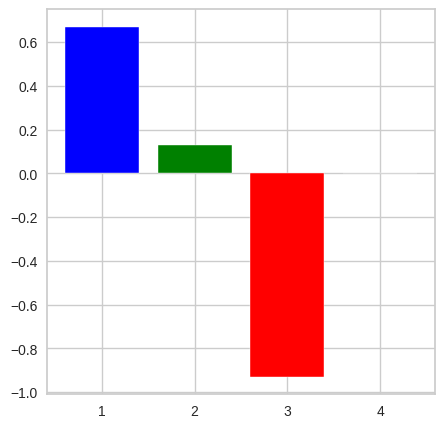

In [78]:
plt.figure(figsize=(5,5))
height = [0.67, 0.13, -0.93, -0.00]
bars = ('1', '2', '3', '4')
x_pos = np.arange(len(bars))
# création des barres
plt.bar(x_pos, height, color=['blue', 'green', 'red', 'purple'])
# Nom des groupes
plt.xticks(x_pos, bars)
# visualisation
plt.show()

**Observations**

* Groupe 1 = pays qui dispose des plus importantes disponibilités, qui importe le plus de volaille, qui a le plus fort PIB,son TDI est élevé et son TAS faible. Meilleure stabilité politique.
* Groupe 2 = pays qui dispose du TAS le plus élevé ,son TDI est le 2eme plus faible, 2eme plus grosses disponibilités après le groupe 1,sa croissance démographique est la plus faible. 2eme meilleure stabilité politique
* Groupe 3 = pays qui dispose du plus grand nombre d'habitant, et plus grande croissance démographique avec le groupe 4, 2eme TAS le plus élevé, TDI le plus faible, Pays qui importe trés peu de volaille en quantité,Pib le plus faible,dispose des plus faibles disponibilités, trés forte inflation, trés forte instabilité politique.
* Groupe 4 = pays qui dispose du TDI le plus élevé, TAS le plus faible,plus forte croissance démographique,2eme groupe qui importe le plus de volaille en quantité,ses disponibilités sont les 2emes plus faibles,PIb faible, 2eme Pib le plus faible,2eme plus forte inflation.Pas d'instabilité politique 

l'analyse des moyennes nous permet de compléter l'analyse en ACP

### **. Analyse géographique des clusters**

Avant de finaliser notre choix de cluster interessons nous à la position géographique de ces pays

**Répartition des Groupes**

In [79]:
df.reset_index(level=0, inplace=True)

In [80]:
df.head()

Zone  nb_habitant  Croiss.dem  Import_Volaille  TDI volaille (%)  \
0  Afrique du Sud        57.01       26.78            514.0             24.27   
1         Albanie         2.88       -7.83             38.0             80.85   
2         Algérie        41.39       33.33              2.0              0.72   
3       Allemagne        82.66        1.54            842.0             48.42   
4          Angola        29.82       81.86            277.0             86.83   

   TAS volaille (%)  dispo animale  dispo volaille  dispo Prot.animale  \
0             78.71          11.67            6.41               31.09   
1             27.66           4.23            1.30               17.54   
2             99.28           2.43            0.80                7.68   
3             87.06           9.46            2.06               28.30   
4             13.17           4.42            1.85               16.88   

   pib_hab_US$  Inflation (%)  Stab_poltiq.  Groupe kmeans  
0      6121.88           6.90         -0.28              1  
1      4514.20           3.92          0.38              4  
2      4109.70           5.04         -0.92              3  
3     44651.83           2.76          0.59              1  
4      4095.81          28.91         -0.33              4

In [81]:
# Groupe 1 K_means
Groupe1=df.loc[df['Groupe kmeans']==1]
list1=Groupe1['Zone'].values.tolist()
len(list1)

37

In [82]:
# Groupe 2 K_means
Groupe2=df.loc[df['Groupe kmeans']==2]
list2=Groupe2['Zone'].values.tolist()
len(list2)

55

In [83]:
# Groupe 3 K_means
Groupe3=df.loc[df['Groupe kmeans']==3]
list3=Groupe3['Zone'].values.tolist()
len(list3)

38

In [84]:
# Groupe 4 K_means
Groupe4=df.loc[df['Groupe kmeans']==4]
list4=Groupe4['Zone'].values.tolist()
len(list4)

36

**Préparation des datas**

On crée un Dataframe avec la localisation du pays par l'ISO alpha3

In [85]:
ISOMAP=pd.read_csv('ISOMAP.csv')
ISOMAP.head()

Zone Code alpha-3  Capitale Continent
0     Afghanistan          AFG    Kaboul      Asie
1  Afrique du Sud          ZAF  Pretoria   Afrique
2         Albanie          ALB    Tirana    Europe
3         Algérie          DZA     Alger   Afrique
4       Allemagne          DEU    Berlin    Europe

On le merge avec notre fichier afin d'obtenir le num de cluster

In [86]:
MAP = ISOMAP.merge(df, how='inner', on='Zone')
MAP.head()

Zone Code alpha-3  Capitale Continent  nb_habitant  Croiss.dem  \
0  Afrique du Sud          ZAF  Pretoria   Afrique        57.01       26.78   
1         Albanie          ALB    Tirana    Europe         2.88       -7.83   
2         Algérie          DZA     Alger   Afrique        41.39       33.33   
3       Allemagne          DEU    Berlin    Europe        82.66        1.54   
4          Angola          AGO    Luanda   Afrique        29.82       81.86   

   Import_Volaille  TDI volaille (%)  TAS volaille (%)  dispo animale  \
0            514.0             24.27             78.71          11.67   
1             38.0             80.85             27.66           4.23   
2              2.0              0.72             99.28           2.43   
3            842.0             48.42             87.06           9.46   
4            277.0             86.83             13.17           4.42   

   dispo volaille  dispo Prot.animale  pib_hab_US$  Inflation (%)  \
0            6.41               31.09      6121.88           6.90   
1            1.30               17.54      4514.20           3.92   
2            0.80                7.68      4109.70           5.04   
3            2.06               28.30     44651.83           2.76   
4            1.85               16.88      4095.81          28.91   

   Stab_poltiq.  Groupe kmeans  
0         -0.28              1  
1          0.38              4  
2         -0.92              3  
3          0.59              1  
4         -0.33              4

**Représentation carte**

In [87]:
import plotly.express as px
import pandas as pd

In [88]:
map_fig = px.scatter_geo(MAP,
                         locations='Code alpha-3',
                         projection='orthographic',
                         color= 'Groupe kmeans',
                         size="TAS volaille (%)",
                         opacity= .8,
                         hover_name= 'Zone',
                         title= 'Situation géographique des 4 clusters (densité : protéines animales )',
                         hover_data= ['Capitale','Groupe kmeans','nb_habitant','TDI volaille (%)','pib_hab_US$']                       
)
map_fig.show()

In [89]:
map_fig = px.scatter_geo(MAP,
                         locations='Code alpha-3',
                         projection='equirectangular',
                         color= 'Groupe kmeans',
                         size= "TAS volaille (%)",
                         opacity= .8,
                         hover_name= 'Zone',
                         title= 'Situation géographique des 4 clusters (densité : Prot.animal. )',
                         hover_data= ['Capitale','Groupe kmeans','nb_habitant','TDI volaille (%)','pib_hab_US$']                        
)
map_fig.show()

##### *<ins> Focus Groupe 1</ins>* 

In [90]:
groupe1=MAP.loc[MAP['Groupe kmeans']==1]
Nb_Pays_Continent_gp1 = groupe1.groupby('Continent')['Zone'].nunique()
print(Nb_Pays_Continent_gp1)

Continent
Afrique              1
Amérique du Nord    10
Asie                 9
Europe              12
Océanie              5
Name: Zone, dtype: int64


In [91]:
map_fig = px.choropleth(groupe1,
                         locations='Code alpha-3',
                         projection='equirectangular',
                         color= "Import_Volaille",
                         color_continuous_scale=px.colors.sequential.Plasma,
                         hover_name= 'Zone',
                         title= 'Situation géographique des Pays du cluster 1 (densité : Import_Volaille )',
                         hover_data= ['Capitale','Groupe kmeans','nb_habitant','TDI volaille (%)','pib_hab_US$']                       
)
map_fig.show()

##### *<ins> Focus Groupe 2</ins>* 

In [92]:
groupe2=MAP.loc[MAP['Groupe kmeans']==2]
Nb_Pays_Continent_gp2 = groupe2.groupby('Continent')['Zone'].nunique()
print(Nb_Pays_Continent_gp2)

Continent
Afrique              4
Amérique du Nord    11
Amérique du Sud     10
Asie                 9
Europe              20
Océanie              1
Name: Zone, dtype: int64


In [93]:
map_fig = px.choropleth(groupe2,
                         locations='Code alpha-3',
                         projection='equirectangular',
                         color= "Import_Volaille",
                         color_continuous_scale=px.colors.sequential.Plasma,
                         hover_name= 'Zone',
                         title= 'Situation géographique des Pays du cluster 2 (densité : Import_Volaille )',
                         hover_data= ['Capitale','Groupe kmeans','nb_habitant','TDI volaille (%)','pib_hab_US$']                          
)
map_fig.show()

##### *<ins> Focus Groupe 3</ins>* 

In [94]:
groupe3=MAP.loc[MAP['Groupe kmeans']==3]
Nb_Pays_Continent_gp3 = groupe3.groupby('Continent')['Zone'].nunique()
print(Nb_Pays_Continent_gp3)

Continent
Afrique    23
Asie       14
Europe      1
Name: Zone, dtype: int64


In [95]:
map_fig = px.choropleth(groupe3,
                         locations='Code alpha-3',
                         projection='equirectangular',
                         color= "Import_Volaille",
                         color_continuous_scale=px.colors.sequential.Plasma,
                         hover_name= 'Zone',
                         title= 'Situation géographique des Pays du cluster 2 (densité : Import_Volaille )',
                         hover_data= ['Capitale','Groupe kmeans','nb_habitant','TDI volaille (%)','pib_hab_US$'] 
)
map_fig.show() 

##### *<ins> Focus Groupe 4</ins>* 

In [96]:
groupe4=MAP.loc[MAP['Groupe kmeans']==4]
Nb_Pays_Continent_gp4 = groupe4.groupby('Continent')['Zone'].nunique()
print(Nb_Pays_Continent_gp4)

Continent
Afrique             16
Amérique du Nord     3
Amérique du Sud      1
Asie                11
Europe               2
Océanie              3
Name: Zone, dtype: int64


In [97]:
map_fig = px.choropleth(groupe4,
                         locations='Code alpha-3',
                         projection='equirectangular',
                         color= "Import_Volaille",
                         color_continuous_scale=px.colors.sequential.Plasma,
                         hover_name= 'Zone',
                         title= 'Situation géographique des Pays du cluster 2 (densité : Import_Volaille. )',
                         hover_data= ['Capitale','Groupe kmeans','nb_habitant','TDI volaille (%)','pib_hab_US$']                        
)
map_fig.show()

### **. Synthèse et choix du cluster**

 * Le Groupe n°2 : exclu de la selection
 Le groupe 2 est complètement autonome dans la gestion de ses disponibilité animale, le groupe privilégie la production plutot que les importations.La quantité de volaille importée est plus faible que les groupes 1 et 2. 

* Le Groupe n°3 : exclu de la selection 
    Le groupe a les disponibilités les plus faibles , le régime alimentaire est faible en protéine animale.Le Groupe est en autonomie et importe trés peu de volaille.Le Pib et la stabilité politique sont dégradés celà a un impact sur les disponibilités qui s'amenuisent.De même l'inflation forte a également un impact sur le niveau des disponibilité.
    Les pays concernés par ce groupe sont majoritairement constitués de pays africains à hauteur de 61% et de pays asiatiques pour 37%.

* Les groupes 1 et 4 sont les groupes qui offrent le plus de potentiel marché, en effet la nécessité d'importée est avérée (TAS faible, TDI élevé), cependant le groupe 4 est marqué par une forte inflation et un Pib trés faible ce qui peu avior un impact sur la consommation et freiner les acha&ts. Notre choix se portera donc sur le Groupe n°1 qui dispose d'une inflationn maitrisée, d'une excellente stabilité poltique et d'un trés bon niveau de PIB.De plus la quantité de volaille importée par ce groupe est 3.5fois plus élevée que celle du groupe 4

Choix du cluster n°1

# **.Analyse du cluster n°1**

Le groupe est constitué de : 

* 1 pays d'Afrique             
* 10 pays d'Amérique du Nord    
* 9 pays d'Asie                
* 12 pays d'Europe              
* 5 pays Océanie              

Nous nous interessons ici au volume importé. Plus la quantité importée est forte et plus le marché peut représenter un potentiel de volume exporté interessant.

In [98]:
groupe1.sort_values(by = ['Import_Volaille'], ascending = False).head(10)

Zone Code alpha-3  \
78                                               Japon          JPN   
101                                            Mexique          MEX   
30                            Chine - RAS de Hong-Kong          HKG   
3                                            Allemagne          DEU   
133  Royaume-Uni de Grande-Bretagne et d'Irlande du...          GBR   
6                                      Arabie saoudite          SAU   
0                                       Afrique du Sud          ZAF   
55                                              France          FRA   
45                                 Émirats arabes unis          ARE   
28                                              Canada          CAN   

      Capitale         Continent  nb_habitant  Croiss.dem  Import_Volaille  \
78       Tokyo              Asie       127.50       -0.02           1069.0   
101     Mexico  Amérique du Nord       124.78       26.17            972.0   
30           -              Asie         7.31       10.60            907.0   
3       Berlin            Europe        82.66        1.54            842.0   
133    Londres            Europe        66.73       13.24            779.0   
6        Riyad              Asie        33.10       60.19            722.0   
0     Pretoria           Afrique        57.01       26.78            514.0   
55       Paris            Europe        64.84        9.87            506.0   
45   Abu Dhabi              Asie         9.49      202.71            433.0   
28      Ottawa  Amérique du Nord        36.73       20.09            182.0   

     TDI volaille (%)  TAS volaille (%)  dispo animale  dispo volaille  \
78              44.27             91.72           8.90            3.20   
101             23.04             77.01           9.42            4.37   
30             323.93              8.57          21.89            6.90   
3               48.42             87.06           9.46            2.06   
133             34.87             81.20           9.05            3.53   
6               50.31             42.93          10.22            7.94   
0               24.27             78.71          11.67            6.41   
55              32.17            111.25           9.40            2.43   
45             105.10             11.65          10.30            6.93   
28              12.70             98.88           8.96            4.22   

     dispo Prot.animale  pib_hab_US$  Inflation (%)  Stab_poltiq.  \
78                20.90     38672.41           0.70          1.11   
101               25.11      9287.84           6.97         -0.72   
30                50.17     46705.03           1.13          0.83   
3                 28.30     44651.83           2.76          0.59   
133               30.07     40448.37           2.26          0.33   
6                 23.51     20802.46          -0.82         -0.58   
0                 31.09      6121.88           6.90         -0.28   
55                28.27     38720.65           1.09          0.28   
45                21.80     40644.80           1.21          0.62   
28                27.50     44906.75          -0.98          1.10   

     Groupe kmeans  
78               1  
101              1  
30               1  
3                1  
133              1  
6                1  
0                1  
55               1  
45               1  
28               1

Liste des pays selectionnés:

* 2 Pays Européen : l'Allemagne et la Grande Bretagne
* 4 Pays asiatiques :le Japon, Hong Kong, L'Arabie Saoudite et les Emirats Arabes Unis
* 1 Pays d'Amérique : le Mexique
* 1 Pays d'Afrique : l'Afrique du Sud

In [99]:
print(list1)

['Afrique du Sud', 'Allemagne', 'Antigua-et-Barbuda', 'Arabie saoudite', 'Australie', 'Autriche', 'Bahamas', 'Canada', 'Chine - RAS de Hong-Kong', 'Chine - RAS de Macao', 'Chypre', 'Danemark', 'Émirats arabes unis', "États-Unis d'Amérique", 'France', 'Grenade', 'Irlande', 'Islande', 'Israël', 'Japon', 'Koweït', 'Luxembourg', 'Malte', 'Mexique', 'Mongolie', 'Norvège', 'Nouvelle-Calédonie', 'Nouvelle-Zélande', 'Polynésie française', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Sainte-Lucie', 'Saint-Kitts-et-Nevis', 'Saint-Vincent-et-les Grenadines', 'Samoa', 'Suède', 'Suisse', 'Trinité-et-Tobago']
